# Extended MultistageOT model with auxiliary states applied to in vivo hematopoiesis

In [86]:
import numpy as np
import pandas as pd
import scanpy as sc
import sys
import scipy
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap 
import seaborn as sbn
sys.path.append("../../../../")

import packages.models.tools as tools

Mark the notebook with a date:

In [48]:
datestamp = "20240327"

Define paths for loading and saving results:

In [49]:
################# Define paths: #################
DATA_PATH    = "../../../../data/real_data/dahlin2018/"
RESULTS_PATH = "../../../../results/real_data/dahlin2018/"

filename_data = "20231227_scanpy_processed_matrix_both_no_cc.h5ad" 
filename_data_all_genes = "20240220_scanpy_filtered_all_genes_matrix_both.h5ad" 

In [50]:
plt.rcParams.update({'font.size': 16})

# Load gene expression data:

Load gene expression data:

In [51]:
data = sc.read(DATA_PATH + filename_data)
data_all_genes = sc.read(DATA_PATH + filename_data_all_genes)

In [52]:
data

AnnData object with n_obs × n_vars = 44802 × 4665
    obs: 'sample', 'exp_groups', 'percent_mito', 'n_counts', 'n_counts_log', 'n_genes', 'erythroid_cc_group', 'gephi_1', 'gephi_2', 'umap_1', 'umap_2'
    var: 'ensembl_ids', 'n_cells', 'mean', 'std'
    uns: 'diffmap_evals', 'erythroid_cc_group_colors', 'exp_groups_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_diffmap_', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

The `data` AnnData object only contains the highly variable genes:

In [53]:
data.shape

(44802, 4665)

The full `data_all_genes` AnnData object contains all genes:

In [54]:
data_all_genes.shape

(44802, 17633)

This latter data object, `data_all_genes`, contains normalized counts, but is not log-transformed. We thus create a separate z-scored (zero mean and unit variance) version of the log(1+x) counts dataframe:

In [55]:
#Normalize and log:
data_all_genes_df = pd.DataFrame(data_all_genes.X.toarray(), columns=data_all_genes.var.index, index=data_all_genes.obs.index)
data_all_genes_df = np.log(data_all_genes_df + 1) 

#Z-scaling:
data_all_genes_df_z_values = (data_all_genes_df - data_all_genes_df.mean() )  / data_all_genes_df.std()

# Load downstream computed data

The downstream results have been pre-computed:

In [56]:
cell_fate_probabilities = pd.read_csv(DATA_PATH + "{datestamp}_cell_fate_probabilities.csv".format(datestamp=datestamp), index_col="Unnamed: 0")
marginals = pd.read_csv(DATA_PATH + "{datestamp}_marginals.csv".format(datestamp=datestamp), index_col="Unnamed: 0")
mass_to_terminals = pd.read_csv(DATA_PATH + "{datestamp}_mass_to_terminals.csv".format(datestamp=datestamp), index_col="Unnamed: 0")
pseudotime = pd.read_csv(DATA_PATH + "{datestamp}_pseudotime.csv".format(datestamp=datestamp), index_col="Unnamed: 0")

pseudotime.columns = ['pseudotime']

# Visualize results

Define some colors for each cell type:

In [57]:
cell_types = ['Monocyte',
            'Lymphoid',
            'Meg',
            'Neutrophil',
            'Eos',
            'Baso',
            'Mast',
            'Erythroid','Fate unknown']
 

colors = np.array([[0,	111, 252], 
               [145, 254, 70],
               [30, 191, 193], 
               [208, 4, 38],
               [85, 50, 5],
               [254, 168, 64],
               [26, 136, 19],
               [251, 87, 252],[148, 103, 189]]) #[255,255,255]])

colors = colors/255 

colors_df = pd.DataFrame(colors, index=cell_types, columns=['R','G','B'])

Extract UMAP-embedding coordinates in a separate DataFrame:

In [58]:
embedding = -data.obs[['umap_1','umap_2']]
embedding = (embedding - embedding.min()) / (embedding.max() - embedding.min()) 

# Input data

Below is the UMAP representation of the scRNA-seq data:

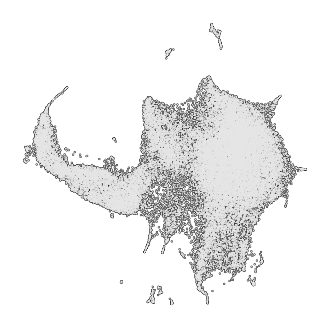

In [59]:
fig, ax = plt.subplots(figsize=(4,4))

plt.scatter(embedding['umap_1'],embedding['umap_2'], edgecolor='none', facecolor='k',s = 2.5)
plt.scatter(embedding['umap_1'],embedding['umap_2'], 
            facecolor=[0.9,0.9,0.9], edgecolor='none',s = 1)
 
sbn.despine(bottom=True, left=True) 
plt.xticks([]) 
plt.yticks([]) 

Load root indices used in solving the problem:

In [60]:
initial_cells = np.load(DATA_PATH + "{datestamp}_all_root_indices.npy".format(datestamp=datestamp)).tolist()
print(len(initial_cells), "initial cells")

40 initial cells


In [61]:
terminal_cells = mass_to_terminals.index
print(len(terminal_cells), "terminal cells")

252 terminal cells


Create a dictionary mapping cell type annotation to terminal cells: 

In [62]:
fate_groups = { annotation : cell_fate_probabilities.loc[terminal_cells].loc[cell_fate_probabilities.loc[terminal_cells].idxmax(axis=1) == annotation].index for annotation in cell_fate_probabilities.columns if (annotation != 'Fate unknown') }

This is a visualization of all the initial (black), intermediate (grey) and terminal (colored) cells used as input to our optimal transport model:

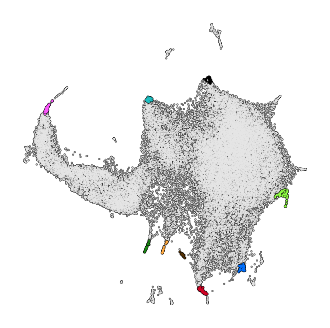

In [63]:
fig, ax = plt.subplots(figsize=(4,4))

plt.scatter(embedding['umap_1'],embedding['umap_2'], edgecolor='none', facecolor='k',s = 2)
plt.scatter(embedding['umap_1'],embedding['umap_2'], 
            facecolor=[0.9,0.9,0.9], edgecolor='none',s = 0.75)


plt.scatter(embedding.loc[initial_cells]['umap_1'],embedding.loc[initial_cells]['umap_2'],
            s = 2, edgecolor='none',facecolor='k')
 

[plt.scatter(embedding.loc[fate_groups[cell_types[k]]]['umap_1'],embedding.loc[fate_groups[cell_types[k]]]['umap_2'],
            s = 4.5, edgecolor='none', facecolor='k') for k in range(len(cell_types[:-1]))]
[plt.scatter(embedding.loc[fate_groups[cell_types[k]]]['umap_1'],embedding.loc[fate_groups[cell_types[k]]]['umap_2'],
            s = 2, edgecolor='none', facecolor=colors[k]) for k in range(len(cell_types[:-1]))]


#plt.title('Pseudotemporal ordering')
sbn.despine(bottom=True, left=True) 
plt.xticks([]) 
plt.yticks([]) 

# Visualize results

## Pseudotime

Below we visualize the pseudotemporal ordering obtained based on the MultistageOT solution:

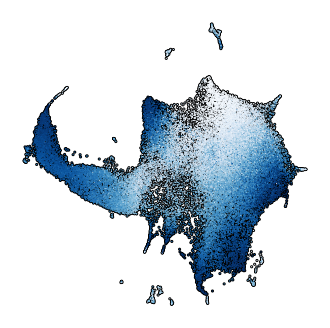

In [64]:
fig, ax = plt.subplots(figsize=(4,4))


ax.scatter(embedding.loc[pseudotime.index, 'umap_1'], embedding.loc[pseudotime.index, 'umap_2'], s=1.5, facecolor='none', edgecolor='k')
ax.scatter(embedding.loc[pseudotime.index, 'umap_1'], embedding.loc[pseudotime.index, 'umap_2'], c=pseudotime.values, edgecolor='none',cmap='Blues', 
           s = 0.75)

sbn.despine(bottom=True, left=True)
plt.xticks([])
plt.yticks([])

Plot a colorbar:

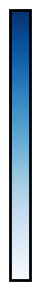

In [65]:

fig = plt.figure(figsize=(8, 3))
ax = fig.add_axes([0., 0., 0.025, 0.9])

cb_pseudotime = matplotlib.colorbar.ColorbarBase(ax, cmap='Blues', 
                                orientation='vertical')
cb_pseudotime.set_ticks([])
cb_pseudotime.outline.set_linewidth(2)
 
 
cb_pseudotime.set_ticklabels([])
plt.show()

## Cell fate probabilities

As described in the manuscript, on this data set we applied our extended MultistageOT model, with three auxiliary states (an auxiliary root, intermediate, and terminal state respectively). These cell states are included when computing cell fate probabilities, here denoted `mass_pool_<type>`, where type $\in \{\text{root}, \text{intermediate}, \text{terminal}\}$. To be clear, note that `root` corresponds to `initial` cells in the manuscript and elsewhere in this notebook.

In [66]:
cell_fate_probabilities.sort_index().iloc[-12:].index

Index(['mass_pool_intermediate', 'mass_pool_intermediate',
       'mass_pool_intermediate', 'mass_pool_intermediate', 'mass_pool_root',
       'mass_pool_root', 'mass_pool_root', 'mass_pool_root',
       'mass_pool_terminal', 'mass_pool_terminal', 'mass_pool_terminal',
       'mass_pool_terminal'],
      dtype='object')

The fate probability DataFrame contains 12 of these auxiliary states, one (3 auxiliary states for each of the 4 partitions). We extract the only the indices corresponding to actual cells:

In [67]:
embedding_indices = cell_fate_probabilities.sort_index().iloc[:-12].index

We visualize the cell fate probabilities for each cell using pie charts, where the size of each wedge is proportional to a fate probability, i.e., the degree of commitment to a given fate:

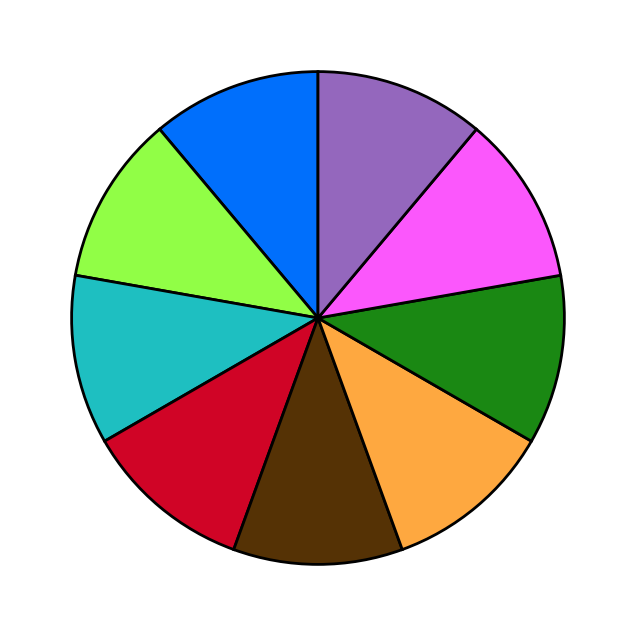

In [68]:
# Plot the pie chart
plt.figure(figsize=(8, 8))

values = np.array([1/cell_fate_probabilities.shape[1] for k in range(cell_fate_probabilities.shape[1])]) 

plt.pie(values, colors=colors,  
        startangle=90, 
        wedgeprops={ 'linewidth' : 2, 'edgecolor' : 'k',  'antialiased': True});

Visualize cell fate probabilities:

 Plotting cell nr 44800/44800

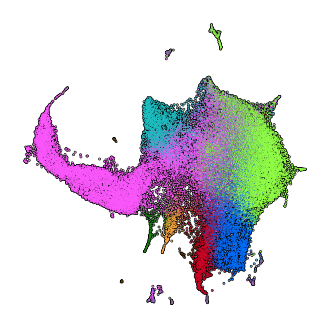

In [43]:
# Create the scatter plot

fig, ax = plt.subplots(figsize=(4,4))


tools.plot_fate_probabilities_with_pie_charts(ax,embedding.loc[embedding_indices],
                                cell_fate_probabilities.loc[embedding_indices],
                                entropy_fade=False, frac=1, plot_order=cell_types, s=1, colors=colors, background=0.25)
# Show the plot
sbn.despine()
ax.get_legend().remove()
sbn.despine(bottom=True, left=True)
plt.xticks([])
plt.yticks([])

Zoom-in on some outliers

 Plotting cell nr 21/44800

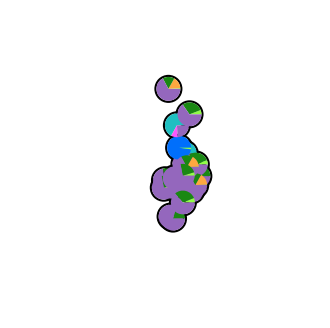

In [69]:
# Create the scatter plot

fig, ax = plt.subplots(figsize=(4,4))

zoom_in_cells = embedding.loc[embedding_indices].loc[(embedding.loc[embedding_indices,'umap_1'] > 0.83) & (embedding.loc[embedding_indices,'umap_2'] < 0.17) &
(embedding.loc[embedding_indices,'umap_2'] > 0.14)].index

tools.plot_fate_probabilities_with_pie_charts(ax,embedding.loc[embedding_indices],
                                cell_fate_probabilities.loc[embedding_indices],
                                entropy_fade=False, frac=1, plot_order=cell_types, indices=zoom_in_cells,s=1, colors=colors, background=350)
# Show the plot
sbn.despine()
ax.get_legend().remove()
sbn.despine(bottom=True, left=True)
plt.xlim([0.81,0.87])
plt.ylim([0.125,0.185])
plt.xticks([])
plt.yticks([])

Below we plot known gene markers corresponding to various fates, with transparency proportional to the expression level:

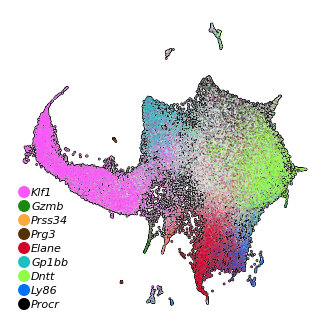

In [70]:
import matplotlib.font_manager as font_manager


fig, ax1 = plt.subplots(figsize=(4,4))

font = font_manager.FontProperties(style='italic')

ax1.scatter(embedding['umap_1'],embedding['umap_2'], facecolor='none', edgecolor='k',s = 1,zorder=-1)
ax1.scatter(embedding['umap_1'],embedding['umap_2'], facecolor=[0.9,0.9,0.9], edgecolor='none',s = 0.75,zorder=0) 



gene_list = ['Procr','Ly86','Dntt','Gp1bb','Elane','Prg3','Prss34','Gzmb','Klf1']

annotation_colors = np.concatenate((np.array([[0,0,0]]), colors),axis=0)
zorder = [1,9,2,3,4,10,6,7,8]
for i in range(len(gene_list)):
    
    #gene_exp = pd.Series(data_all_genes[:,gene_list[i]].X.toarray().flatten(), index=data_all_genes.obs.index)
    gene_exp = data_all_genes_df_z_values[gene_list[i]]
    plot_order = gene_exp.sort_values(ascending=True).index
    gene_exp_sorted = gene_exp.loc[plot_order]
    
    alpha = (gene_exp_sorted - np.min(gene_exp_sorted) ) / (np.max(gene_exp_sorted) - np.min(gene_exp_sorted) )
    ax1.scatter(embedding.loc[plot_order]['umap_1'],embedding.loc[plot_order]['umap_2'], s=1, alpha=alpha, facecolor=annotation_colors[i], edgecolor='none',zorder=zorder[i])
    ax1.scatter(0,0.05*i, s=75,  facecolor=annotation_colors[i], edgecolor='none',zorder=zorder[i])
    ax1.text(0.025,0.05*i-0.015, gene_list[i], fontproperties=font, fontsize=8)

sbn.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])

### Correlate expression level of marker genes with MSOT's inferred commitment to the corresponding fate:

In [71]:
fate_to_gene_dict = {'Lymphoid' : 'Dntt', 
                    'Monocyte' : 'Ly86', 
                    'Meg' : 'Gp1bb', 
                    'Neutrophil' : 'Elane', 
                    'Eos' : 'Prg3',
                    'Baso' : 'Prss34', 
                    'Mast' : 'Gzmb',
                    'Erythroid' :'Klf1'}

Compute correlation between fate commitment and log(x+1)-transformed gene expression levels:

In [72]:
fate_correlations = []
for fate in cell_types[:-1]:
    fate_correlations.append(pd.DataFrame([np.corrcoef(data_all_genes_df_z_values.loc[embedding_indices, fate_to_gene_dict[f]], 
                                            cell_fate_probabilities.loc[embedding_indices,fate])[0,1] for f in fate_to_gene_dict], index=[fate_to_gene_dict[f] for f in fate_to_gene_dict], columns=[fate]))
fate_correlations = pd.concat(fate_correlations,axis=1)

This following table shows how the fate probabilities for each fate correlates with the different marker gene Z-scores:

In [73]:
fate_correlations

Monocyte  Lymphoid       Meg  Neutrophil       Eos      Baso  \
Dntt   -0.106145  0.591077 -0.124671   -0.125979 -0.049026 -0.058642   
Ly86    0.362371 -0.052509 -0.056768   -0.020986 -0.022453 -0.020580   
Gp1bb  -0.142434 -0.177459  0.662518   -0.085952 -0.031202 -0.022079   
Elane   0.297860 -0.246825 -0.098316    0.648773  0.215457  0.063580   
Prg3   -0.015456 -0.035446 -0.015635    0.019368  0.612741  0.051351   
Prss34 -0.027199 -0.037557 -0.015551   -0.011032  0.029838  0.470691   
Gzmb   -0.030843 -0.042144 -0.014611   -0.019287 -0.007005 -0.004236   
Klf1   -0.292005 -0.386846 -0.110875   -0.178759 -0.059074 -0.037168   

            Mast  Erythroid  
Dntt   -0.048167  -0.324327  
Ly86    0.000531  -0.140609  
Gp1bb  -0.022447  -0.065895  
Elane  -0.017185  -0.195364  
Prg3   -0.005035  -0.034593  
Prss34  0.003396  -0.036771  
Gzmb    0.640082  -0.031255  
Klf1   -0.005657   0.668864

We can check which marker genes have the highest correlations to each fate:

In [74]:
fate_correlations.idxmax(axis=0)

Monocyte        Ly86
Lymphoid        Dntt
Meg            Gp1bb
Neutrophil     Elane
Eos             Prg3
Baso          Prss34
Mast            Gzmb
Erythroid       Klf1
dtype: object

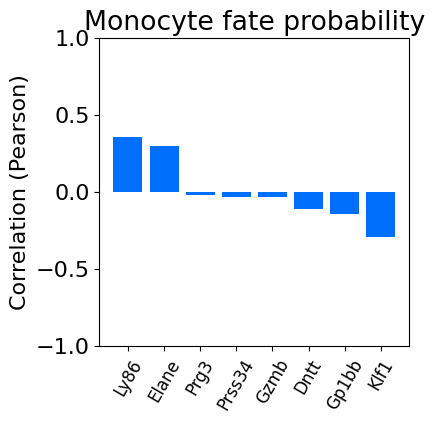

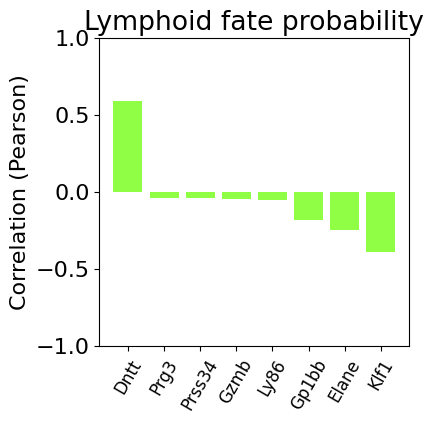

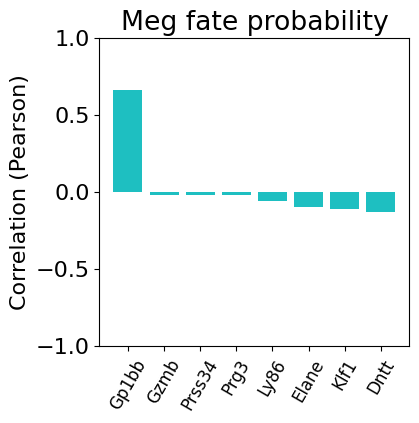

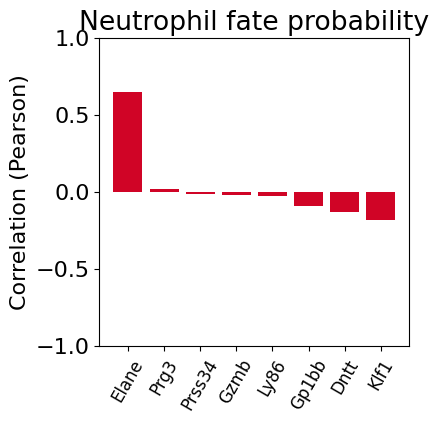

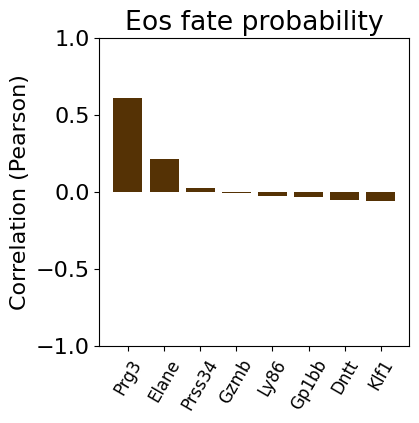

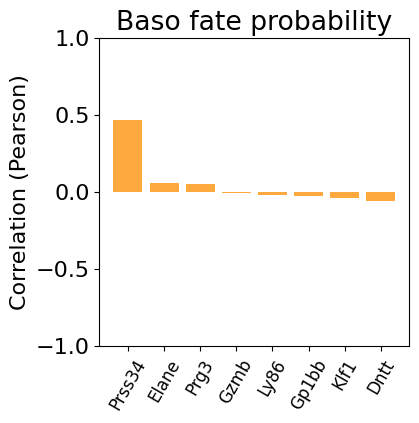

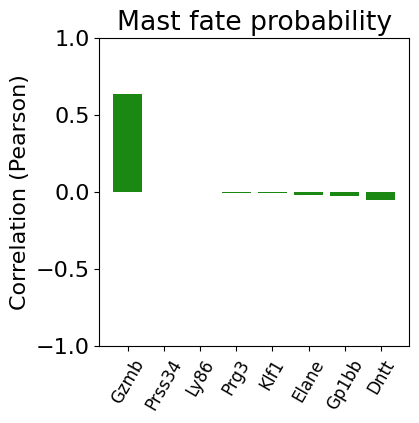

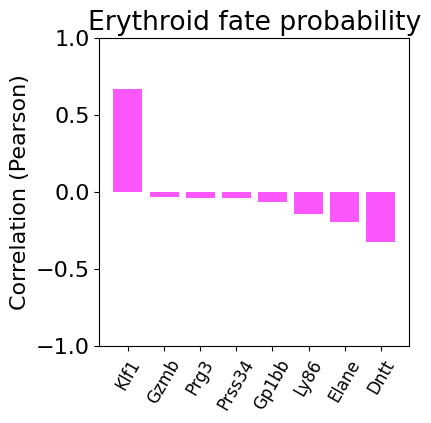

In [75]:
for fate in fate_correlations.columns:
    plt.figure(figsize=(4,4))
    corr = fate_correlations[fate].sort_values(ascending=False)
    plt.bar(corr.index, corr.values, color=colors_df.loc[fate].values)
    plt.xticks(rotation=60, fontsize=12)
    plt.grid(alpha=0)
    plt.ylim([-1,1])
    plt.title(fate + " fate probability")
    plt.ylabel('Correlation (Pearson)')


Visualize top correlations with a bar plot:

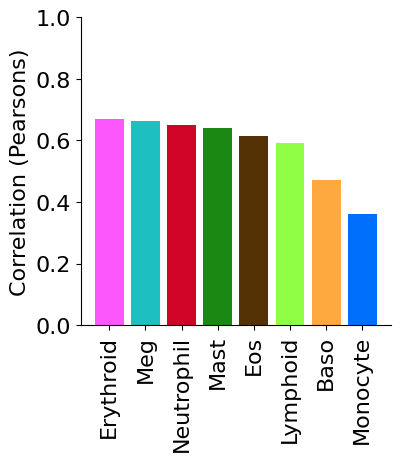

In [76]:
top_correlation = fate_correlations.max(axis=0)
top_genes = fate_correlations.idxmax()
order = top_correlation.sort_values(ascending=False).index

plt.figure(figsize=(4,4))
plt.bar(order, top_correlation[order], color=colors_df.loc[order].values)
#[plt.text(fate, top_correlation[fate], top_genes[fate], rotation=90) for fate in top_correlation.index]
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Correlation (Pearsons)',fontsize=16)
sbn.despine()
plt.ylim([0,1])
plt.grid(alpha=0)

Isolate MC/Baso progenitors

In [77]:
threshold = 0.1
others = [cell_type for cell_type in cell_fate_probabilities.columns if cell_type not in ['Mast', 'Baso']]

mc_baso_progenitors = cell_fate_probabilities.loc[(cell_fate_probabilities['Mast'] > threshold) & 
                                                  (cell_fate_probabilities['Baso']  > threshold) &
                                                  (cell_fate_probabilities[others].sum(axis=1) < 0.01)].index

In [78]:
print("Number of putative MC/Baso progenitors:", len(mc_baso_progenitors))

Number of putative MC/Baso progenitors: 35


 Plotting cell nr 35/44800

([], [])

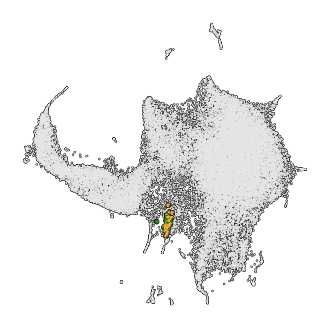

In [79]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(embedding.loc[pseudotime.index, 'umap_1'], embedding.loc[pseudotime.index, 'umap_2'], s=0.5, facecolor='none', edgecolor='k')
ax.scatter(embedding.loc[pseudotime.index, 'umap_1'], embedding.loc[pseudotime.index, 'umap_2'], color=[0.9,0.9,0.9], edgecolor='none', s = 1)

np.random.seed(123)
tools.plot_fate_probabilities_with_pie_charts(ax,embedding.loc[embedding_indices],
                                cell_fate_probabilities.loc[embedding_indices],
                                entropy_fade=False, frac=1, plot_order=cell_types, indices=mc_baso_progenitors, s=10, colors=colors, background=6)
# Show the plot
sbn.despine()
ax.get_legend().remove()
sbn.despine(bottom=True, left=True)
plt.xticks([])
plt.yticks([])

 Plotting cell nr 35/1927

([], [])

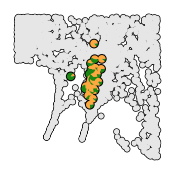

In [80]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(2,2))

embedding_zoom = embedding.loc[(embedding['umap_1'] > 0.375) & (embedding['umap_1'] < 0.625) &
                               (embedding['umap_2'] > 0.15) & (embedding['umap_2'] < 0.4)]
embedding_zoom = (embedding_zoom - embedding_zoom.min()) / (embedding_zoom.max() - embedding_zoom.min())
ax.scatter(embedding_zoom['umap_1'], embedding_zoom['umap_2'], s=15, facecolor='none', edgecolor='k')
ax.scatter(embedding_zoom['umap_1'], embedding_zoom['umap_2'], color=[0.9,0.9,0.9], edgecolor='none', s = 15)

np.random.seed(123)
tools.plot_fate_probabilities_with_pie_charts(ax,embedding_zoom,
                                cell_fate_probabilities.loc[embedding_zoom.index],
                                entropy_fade=False, frac=1, plot_order=cell_types, indices=mc_baso_progenitors, s=140, colors=colors, background=30)
# Show the plot
sbn.despine()
ax.get_legend().remove()
sbn.despine(bottom=True, left=True)
#ax.set_xlim([0.4,0.6])
#ax.set_ylim([0.2,0.4])
plt.xticks([])
plt.yticks([])

Visualizing gene expression of mc/basophil-associated genes

In [81]:
# Create a color_map for clearer annotation
color_list = ['lightgrey', 'tomato', 'firebrick', 'darkred']
cmap_gene = LinearSegmentedColormap.from_list("color_trial", colors=color_list) 

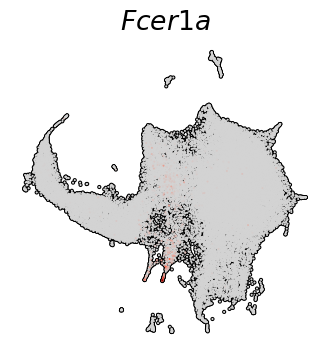

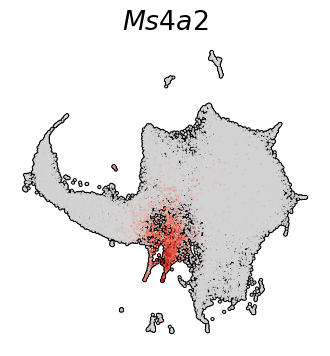

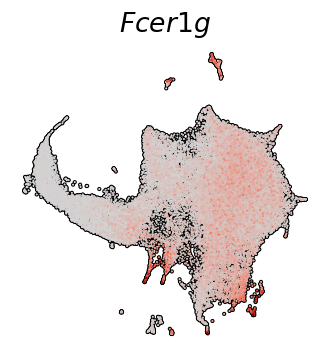

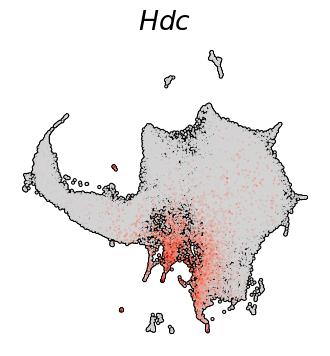

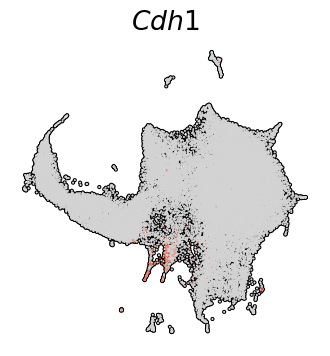

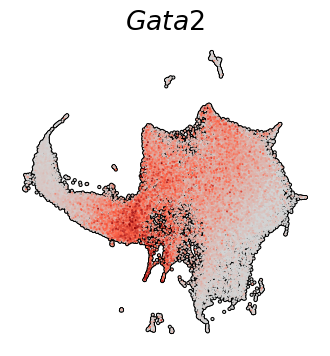

In [82]:
for gene in ['Fcer1a', 'Ms4a2','Fcer1g', 'Hdc', 'Cdh1', 'Gata2']:
    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(4,4))
    plot_order = np.argsort(data_all_genes[embedding.index,gene].X.toarray().flatten())
    gene_exp = np.sort(data_all_genes[embedding.index,gene].X.toarray().flatten())
    embedding = embedding.loc[embedding.index[plot_order]]

    ax.scatter(embedding['umap_1'], embedding['umap_2'], s=4, facecolor='none', edgecolor='k')
    ax.scatter(embedding['umap_1'], embedding['umap_2'], c=gene_exp, cmap=cmap_gene,edgecolor='none', s = 2)
    ax.set_title('$'+gene+'$') 
    sbn.despine(bottom=True, left=True)
    #ax.set_xlim([0.4,0.6])
    #ax.set_ylim([0.2,0.4])
    ax.set_xticks([])
    ax.set_yticks([])

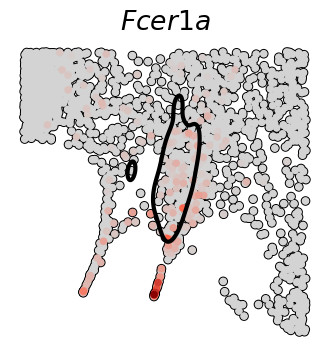

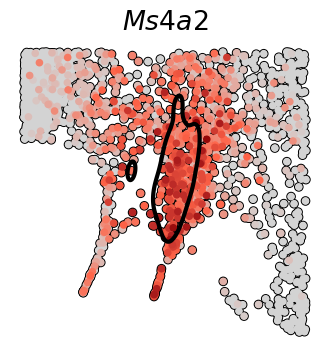

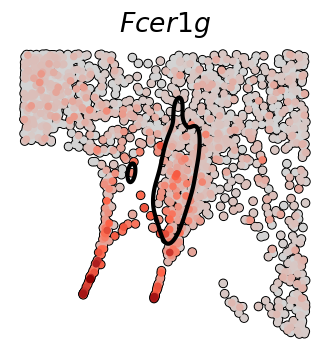

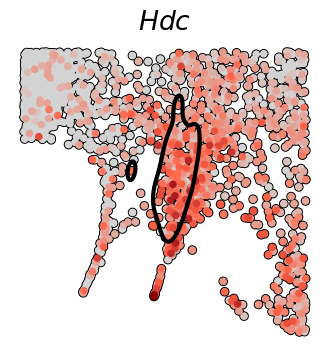

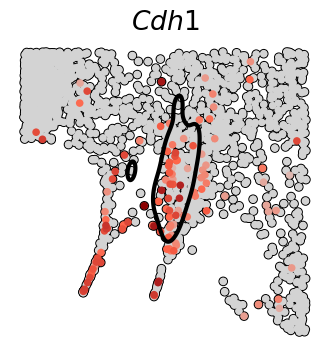

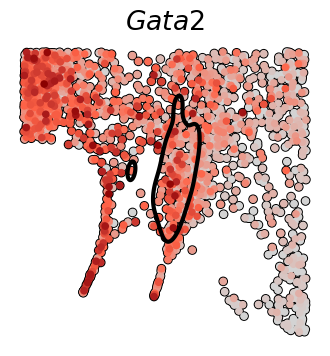

In [83]:
for gene in ['Fcer1a', 'Ms4a2','Fcer1g', 'Hdc', 'Cdh1', 'Gata2']:
    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(4,4))
    plot_order = np.argsort(data_all_genes[embedding_zoom.index,gene].X.toarray().flatten())
    gene_exp = np.sort(data_all_genes[embedding_zoom.index,gene].X.toarray().flatten())
    embedding_temp = embedding_zoom.loc[embedding_zoom.index[plot_order]]

    
    ax.scatter(embedding_temp['umap_1'], embedding_temp['umap_2'], s=35, facecolor='none', edgecolor='k')

    ax.scatter(embedding_temp['umap_1'], embedding_temp['umap_2'], c=gene_exp, cmap=cmap_gene, edgecolor='none', s = 30)

    sbn.kdeplot(x=embedding_temp.loc[mc_baso_progenitors,'umap_1'], y=embedding_temp.loc[mc_baso_progenitors, 'umap_2'], fill=False, color='k', alpha=1,levels=[0.09], linestyles='-', linewidths=3)

    ax.set_title('$'+gene+'$') 
    sbn.despine(bottom=True, left=True)
    #ax.set_xlim([0.4,0.6])
    #ax.set_ylim([0.2,0.4])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

### Differential expression analysis:

In [84]:
#Make a copy of the gene data:
data_bmcp_analysis = data_all_genes[pseudotime.index].copy()

#Log transform data:
sc.pp.log1p(data_bmcp_analysis)

#Add group
data_bmcp_analysis.obs["group"] = pd.Series(['bmcp' if (idx in mc_baso_progenitors) else 'other' for idx in data_bmcp_analysis.obs_names], index=data_bmcp_analysis.obs_names).astype('category')

Run statistical test for significantly differentially expressed genes:

In [87]:
bmcp_gene_df = pd.DataFrame(data_bmcp_analysis[data_bmcp_analysis.obs['group'] == 'bmcp'].X.toarray(), columns=data_bmcp_analysis.var_names)
other_gene_df = pd.DataFrame(data_bmcp_analysis[data_bmcp_analysis.obs['group'] == 'other'].X.toarray(), columns=data_bmcp_analysis.var_names)


bmcp_gene_counts_df = np.exp(bmcp_gene_df)-1
other_gene_counts_df = np.exp(other_gene_df)-1
lfc = np.log2( bmcp_gene_counts_df.mean() / other_gene_counts_df.mean() )

n_genes = len(data_bmcp_analysis.var_names)

pval_list = []
for i in range(7):
    print(i)
    genes = data_bmcp_analysis.var_names[i * n_genes // 7: (i+1) * n_genes // 7]
    res = scipy.stats.mannwhitneyu(bmcp_gene_df[genes], other_gene_df[genes])
    pval_list += res[1].tolist()

/Users/magnus/.conda/envs/manuscript_1/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0
1
2
3
4
5
6


Adjust $p$-values for false discovery rate: 

In [88]:
pvals_adj = scipy.stats.false_discovery_control(pval_list, method='bh')

Create new dataframe:

In [89]:
test_res_df = pd.DataFrame(lfc, columns=['lfc'])
test_res_df['pval_adj'] = pvals_adj

In [90]:
test_res_df.sort_values(by='pval_adj')

lfc       pval_adj
Rnase12        6.036158  1.422638e-287
Ms4a2          6.036670  5.543561e-203
Cdh1           6.818511  4.375588e-154
Gm11697        5.201333   9.287990e-97
Mfsd7c         9.354227   7.019259e-91
...                 ...            ...
Sf3b6          0.033762   9.991343e-01
Sfxn2          0.079737   9.995681e-01
Gm12802       -1.006447   9.996753e-01
4833418N02Rik  0.186981   9.997482e-01
Gm4285        -0.359919   9.998188e-01

[17633 rows x 2 columns]

Volcano plot:

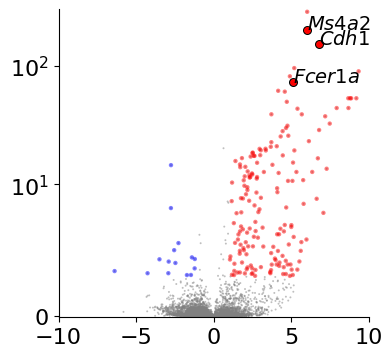

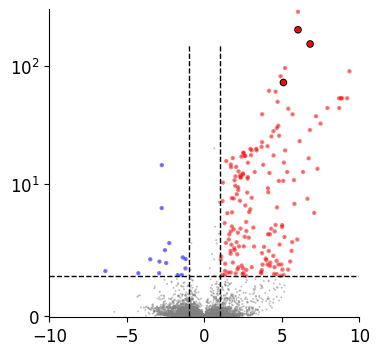

In [91]:
fig, ax1 = plt.subplots(figsize=(4,4))
fdr = 0.001
plt.rcParams['font.size'] = 14
# plot the same data on both Axes
ax1.scatter(test_res_df['lfc'], -np.log10(test_res_df['pval_adj']),s=2,edgecolor='none',facecolor='grey', alpha=0.5)

dge_up = test_res_df.loc[(test_res_df['lfc'] > 1) & (test_res_df['pval_adj'] < fdr)].index
dge_down = test_res_df.loc[(test_res_df['lfc'] < -1) & (test_res_df['pval_adj'] < fdr)].index
ax1.scatter(test_res_df.loc[dge_up,'lfc'], -np.log10(test_res_df.loc[dge_up,'pval_adj']),s=10,edgecolor='none',facecolor='r',alpha=0.5)
ax1.scatter(test_res_df.loc[dge_down,'lfc'], -np.log10(test_res_df.loc[dge_down,'pval_adj']),s=10,edgecolor='none',facecolor='b',alpha=0.5)

genes_to_plot = ['Fcer1a','Ms4a2','Cdh1']
for gene in genes_to_plot:
    ax1.scatter(test_res_df.loc[gene,'lfc'], -np.log10(test_res_df.loc[gene,'pval_adj']),edgecolor='k',s=30)
    if gene in dge_up:
        ax1.scatter(test_res_df.loc[gene,'lfc'], -np.log10(test_res_df.loc[gene,'pval_adj']),facecolor='r',s=15)
    elif gene in dge_down:
        ax1.scatter(test_res_df.loc[gene,'lfc'], -np.log10(test_res_df.loc[gene,'pval_adj']),facecolor='b',s=15)
    else:
        ax1.scatter(test_res_df.loc[gene,'lfc'], -np.log10(test_res_df.loc[gene,'pval_adj']),facecolor='grey',s=15)
    ax1.text(test_res_df.loc[gene,'lfc'], -np.log10(test_res_df.loc[gene,'pval_adj']), "$" + gene + "$",color='k')


plt.ylim([-0.1,None])
plt.xlim([-10,10]) 
ax1.set_yscale('symlog', linthresh=10)
sbn.despine()
plt.grid(visible=False)

fig, ax1 = plt.subplots(figsize=(4,4))
plt.rcParams['font.size'] = 14
# plot the same data on both Axes
ax1.hlines(y=-np.log10(fdr), xmin=-10,xmax=10,color='k',linewidth=1, linestyle='dashed')
ax1.vlines(x=-1, ymin=0, ymax=150, linewidth=1, color='k',linestyle='dashed')
ax1.vlines(x=1, ymin=0, ymax=150, linewidth=1, color='k',linestyle='dashed')
ax1.scatter(test_res_df['lfc'], -np.log10(test_res_df['pval_adj']),s=2,edgecolor='none',facecolor='grey', alpha=0.5)

dge_up = test_res_df.loc[(test_res_df['lfc'] > 1) & (test_res_df['pval_adj'] < fdr)].index
dge_down = test_res_df.loc[(test_res_df['lfc'] < -1) & (test_res_df['pval_adj'] < fdr)].index
ax1.scatter(test_res_df.loc[dge_up,'lfc'], -np.log10(test_res_df.loc[dge_up,'pval_adj']),s=10,edgecolor='none',facecolor='r',alpha=0.5)
ax1.scatter(test_res_df.loc[dge_down,'lfc'], -np.log10(test_res_df.loc[dge_down,'pval_adj']),s=10,edgecolor='none',facecolor='b',alpha=0.5)


for gene in genes_to_plot:
    ax1.scatter(test_res_df.loc[gene,'lfc'], -np.log10(test_res_df.loc[gene,'pval_adj']),edgecolor='k', facecolor='none',s=20)
    if gene in dge_up:
        ax1.scatter(test_res_df.loc[gene,'lfc'], -np.log10(test_res_df.loc[gene,'pval_adj']),edgecolor='none', facecolor='r',s=15)
    elif gene in dge_down:
        ax1.scatter(test_res_df.loc[gene,'lfc'], -np.log10(test_res_df.loc[gene,'pval_adj']),edgecolor='none',facecolor='b',s=15)
    else:
        ax1.scatter(test_res_df.loc[gene,'lfc'], -np.log10(test_res_df.loc[gene,'pval_adj']),edgecolor='none',facecolor='grey',s=15)

plt.ylim([-0.1,None])
plt.xlim([-10,10]) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax1.set_yscale('symlog', linthresh=10)
plt.grid(visible=False)
sbn.despine()   

Rank genes based on adjusted $p$-values:

In [92]:
top_genes = test_res_df.copy().sort_values(by='pval_adj',ascending=True)
top_genes['rank'] = np.linspace(1,test_res_df.shape[0],test_res_df.shape[0])
top_genes.loc[['Fcgr3','Fcgr2b','Itgb7']]

lfc      pval_adj    rank
Fcgr3   4.165429  1.882248e-62     8.0
Fcgr2b  3.367856  4.583415e-20    37.0
Itgb7   0.099665  9.766423e-01  7482.0

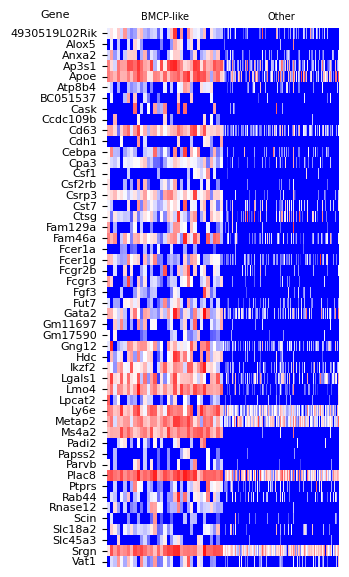

In [93]:
#Select only genes which are expressed in more than half the BMCP subset:
top_genes_filtered = test_res_df.loc[bmcp_gene_df.columns[((bmcp_gene_df > 0).sum(axis=0) > 5).values]]

#Pick top 50 significantly upregulated genes, and sort genes based on gene name:
sorted_top_genes = sorted(top_genes_filtered.loc[top_genes_filtered['lfc'] > 1].sort_values(by='pval_adj').index[:50])

#Concatenate BMCP population and 'other' cells:
heatmap_data = pd.concat((bmcp_gene_df[sorted_top_genes], other_gene_df[sorted_top_genes]))

#Normalize each gene:
heatmap_data = (heatmap_data / heatmap_data.max() ).T

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(3,7))
sbn.heatmap(heatmap_data.iloc[:,:35], ax=ax1, vmin=0, vmax=1,cmap='bwr',cbar=False)
sbn.heatmap(heatmap_data.iloc[:,35:],  ax=ax2, vmin=0, vmax=1,cmap='bwr',cbar=False)
ax1.set_yticks(np.linspace(0.5,len(sorted_top_genes)-0.5, len(sorted_top_genes)), sorted_top_genes,fontsize=8)
ax1.text(-20,-1,"Gene",fontsize=8)
ax2.set_yticks([])
ax1.set_xticks([])
ax2.set_xticks([])
fig.subplots_adjust(wspace=0,hspace=1)
ax1.set_title("BMCP-like",fontsize=7)
ax2.set_title("Other",fontsize=7) 
ax1.grid(visible=False)

Print scipy version:

In [94]:
scipy.__version__

'1.11.0'

In [95]:
colors_dict = {cell_types[i] : colors[i] for i in range(len(colors))}

# Outliers analysis

Our introduction of auxiliary artificial cells allows us to systematically identify outliers. We select cells which have more than 50% probability of ending up in the "Unknown fate" defined by the artificial terminal cell.

In [97]:
threshold = 0.5

outliers = cell_fate_probabilities.loc[(cell_fate_probabilities['Fate unknown'] > threshold)].index
outliers = [outlier for outlier in outliers if ((outlier != 'mass_pool_intermediate') and (outlier != 'mass_pool_terminal') and (outlier != 'mass_pool_root'))]

#We do not analyze root cells:
outliers = [outlier for outlier in outliers if outlier not in initial_cells]

In [98]:
# Create a color_map for clearer annotation 
color_list = [[0.9,0.9,0.9], 'tab:purple']
cmap_outliers =  LinearSegmentedColormap.from_list("color_trial", colors=color_list) 

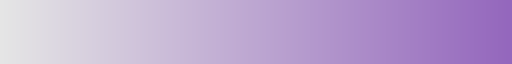

In [99]:
cmap_outliers

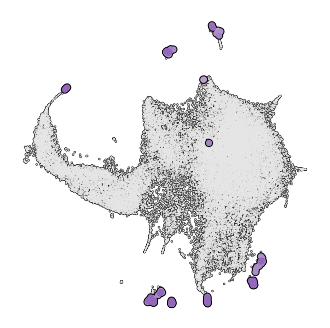

In [100]:
fig, ax = plt.subplots(figsize=(4,4))

embedding = -data.obs[['umap_1','umap_2']]
embedding = (embedding - embedding.min()) / (embedding.max() - embedding.min()) 
plot_order = cell_fate_probabilities.loc[embedding_indices, 'Fate unknown'].sort_values().index

non_outliers = np.array([idx for idx in cell_fate_probabilities.index if (idx not in outliers) and ('mass_pool' not in idx)])
plot_order = cell_fate_probabilities.loc[non_outliers, 'Fate unknown'].sort_values().index
ax.scatter(embedding.loc[plot_order, 'umap_1'], embedding.loc[plot_order, 'umap_2'], s=0.5, facecolor='none', edgecolor='k') 
ax.scatter(embedding.loc[plot_order, 'umap_1'], embedding.loc[plot_order, 'umap_2'], s=1., 
cmap=cmap_outliers,vmin=0., vmax=1, c=cell_fate_probabilities.loc[plot_order, 'Fate unknown'], edgecolor='none') 

plot_order = cell_fate_probabilities.loc[outliers, 'Fate unknown'].sort_values().index
ax.scatter(embedding.loc[plot_order,'umap_1'], embedding.loc[plot_order,'umap_2'], s=24,  facecolor='none', edgecolor='k')
ax.scatter(embedding.loc[plot_order,'umap_1'], embedding.loc[plot_order,'umap_2'], s=20, 
cmap=cmap_outliers,vmin=0., vmax=1, c=cell_fate_probabilities.loc[plot_order, 'Fate unknown'], edgecolor='none')

sbn.despine(left=True,bottom=True)

plt.xticks([])
plt.yticks([])

We next perform a new UMAP clustering looking only at these outlier-cells:

In [101]:
data_for_outliers = data_all_genes.copy()

#Log transform data:
sc.pp.log1p(data_for_outliers)

#Consider only the HVGs:
data_for_outliers = data_for_outliers[:,data.var_names]

In [102]:
#Select only the data corresponding to outliers:

outlier_ann_data = data_for_outliers[outliers].copy()

print(outlier_ann_data)

#Re-scale data before PCA:
sc.tl.pca(outlier_ann_data) 

AnnData object with n_obs × n_vars = 168 × 4665
    obs: 'sample', 'exp_groups', 'percent_mito', 'n_counts', 'n_counts_log', 'n_genes'
    var: 'ensembl_ids', 'n_cells'
    uns: 'log1p'


In [103]:
sc.pp.neighbors(outlier_ann_data, n_neighbors=5, n_pcs=50)
sc.tl.umap(outlier_ann_data,min_dist=0.3, random_state=0) 

sc.tl.leiden(outlier_ann_data, resolution=0.5)

/Users/magnus/.conda/envs/manuscript_1/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/magnus/.conda/envs/manuscript_1/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/magnus/.conda/envs/manuscript_1/lib/python3.9/site-packag

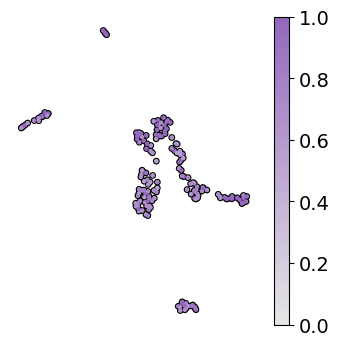

In [105]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(outlier_ann_data.obsm['X_umap'][:,0], outlier_ann_data.obsm['X_umap'][:,1], edgecolor='k', facecolor='none',s=15)
scatter = ax.scatter(outlier_ann_data.obsm['X_umap'][:,0], outlier_ann_data.obsm['X_umap'][:,1], c=cell_fate_probabilities.loc[outlier_ann_data.obs.index, 'Fate unknown'], 
cmap=cmap_outliers, vmin=0, edgecolor='none',s=10)

sbn.despine(bottom=True,left=True)
ax.set_xticks([])
ax.set_yticks([])
cb = fig.colorbar(scatter, ax=ax)
plt.show()

In [106]:
outlier_ann_data

AnnData object with n_obs × n_vars = 168 × 4665
    obs: 'sample', 'exp_groups', 'percent_mito', 'n_counts', 'n_counts_log', 'n_genes', 'leiden'
    var: 'ensembl_ids', 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Visualizing first round of clustering:

([], [])

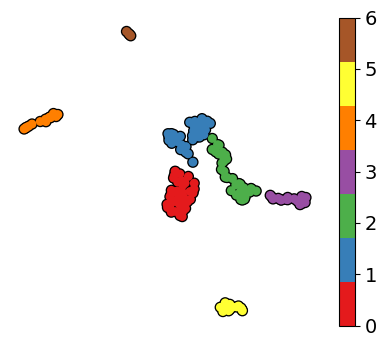

In [107]:
fig = plt.figure(figsize=(5,4))

colors_annotation = plt.get_cmap('Set1')([k for k in range(len(outlier_ann_data.obs['leiden'].unique()))])
cmap = LinearSegmentedColormap.from_list('my_cmap', colors_annotation, N=len(outlier_ann_data.obs['leiden'].unique()))

plt.scatter(outlier_ann_data.obsm['X_umap'][:,0], outlier_ann_data.obsm['X_umap'][:,1], edgecolor='k', linewidth=1.5, facecolor='none',s=45)
plt.scatter(outlier_ann_data.obsm['X_umap'][:,0], outlier_ann_data.obsm['X_umap'][:,1], 
c=outlier_ann_data.obs['leiden'].astype(int).values, cmap=cmap,edgecolor='none',s=40)


plt.colorbar()
sbn.despine(bottom=True,left=True)
plt.xticks([])
plt.yticks([])

Second round of clustering:

In [108]:
sc.tl.leiden(outlier_ann_data, key_added='leiden_sub_1', restrict_to=['leiden', ['0']], resolution=0.4)

In [109]:
sc.tl.leiden(outlier_ann_data, key_added='leiden_sub_2', restrict_to=['leiden_sub_1', ['2']], resolution=0.4)

Rename categories:

In [110]:
outlier_ann_data.obs['leiden_sub_2'] = outlier_ann_data.obs['leiden_sub_2'].cat.rename_categories({
            '0,0': '0', 
            '0,1': '1', 
            '1'  : '2',
            '2,0': '3',
            '2,1': '4', 
            '3'  : '5', 
            '4'  : '6', 
            '5'  : '7',
            '6'  : '8'})

## Visualize clustering results:

### UMAP

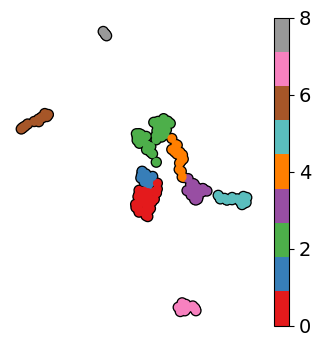

In [111]:
fig = plt.figure(figsize=(4,4))

colors_annotation = plt.get_cmap('Set1')([k for k in range(len(outlier_ann_data.obs['leiden_sub_2'].unique()))])
colors_annotation[5] = [90/255,190/255,190/255,1.]
cmap = LinearSegmentedColormap.from_list('my_cmap', colors_annotation, N=len(outlier_ann_data.obs['leiden_sub_2'].unique()))

plt.scatter(outlier_ann_data.obsm['X_umap'][:,0], outlier_ann_data.obsm['X_umap'][:,1], edgecolor='k', linewidth=1.5, facecolor='none',s=45)
plt.scatter(outlier_ann_data.obsm['X_umap'][:,0], outlier_ann_data.obsm['X_umap'][:,1], 
c=outlier_ann_data.obs['leiden_sub_2'].astype(int), cmap=cmap,edgecolor='none',s=40)


plt.colorbar()
sbn.despine(bottom=True,left=True)
plt.xticks([])
plt.yticks([])
plt.show()


### PCA

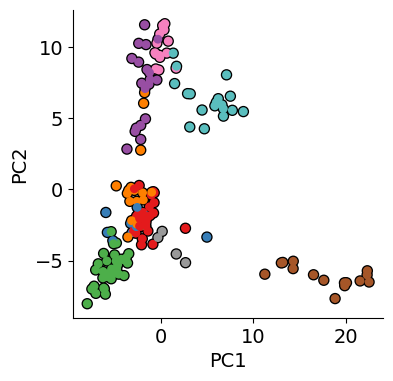

In [112]:
fig = plt.figure(figsize=(4,4))
plt.scatter(outlier_ann_data.obsm['X_pca'][:,0], outlier_ann_data.obsm['X_pca'][:,1], edgecolor='k', linewidth=1.5, facecolor='none',s=45)
plt.scatter(outlier_ann_data.obsm['X_pca'][:,0], outlier_ann_data.obsm['X_pca'][:,1], 
c=outlier_ann_data.obs['leiden_sub_2'].astype(int), cmap=cmap,edgecolor='none',s=40)

sbn.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(visible=False)
plt.show()

### Original UMAP

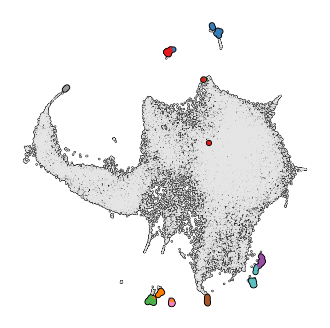

In [113]:
fig, ax = plt.subplots(figsize=(4,4))

embedding = -data.obs[['umap_1','umap_2']]
embedding = (embedding - embedding.min()) / (embedding.max() - embedding.min()) 
ax.scatter(embedding['umap_1'], embedding['umap_2'], s=0.5, facecolor='none', edgecolor='k')
ax.scatter(embedding['umap_1'], embedding['umap_2'], s=1, facecolor=[0.9,0.9,0.9], edgecolor='none')

ax.scatter(embedding.loc[outlier_ann_data.obs.index,'umap_1'], embedding.loc[outlier_ann_data.obs.index,'umap_2'], edgecolor='k', facecolor='none',s=12)
plot = ax.scatter(embedding.loc[outlier_ann_data.obs.index,'umap_1'], embedding.loc[outlier_ann_data.obs.index,'umap_2'], 
c=outlier_ann_data.obs['leiden_sub_2'].astype(int), cmap=cmap,edgecolor='none',s=10)

 
sbn.despine(left=True,bottom=True)
plt.xticks([])
plt.yticks([])
plt.show()


### Gephi-plot from Dahlin *et al*. (2018)

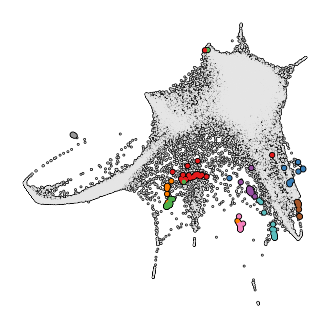

In [114]:
fig, ax = plt.subplots(figsize=(4,4))

embedding = data.obs[['gephi_1','gephi_2']]
embedding = (embedding - embedding.min()) / (embedding.max() - embedding.min()) 
ax.scatter(embedding['gephi_1'], embedding['gephi_2'], s=1., facecolor='none', edgecolor='k')
ax.scatter(embedding['gephi_1'], embedding['gephi_2'], s=1, facecolor=[0.9,0.9,0.9], edgecolor='none')


ax.scatter(embedding.loc[outlier_ann_data.obs.index,'gephi_1'], embedding.loc[outlier_ann_data.obs.index,'gephi_2'], edgecolor='k', facecolor='none',s=12)
plot = ax.scatter(embedding.loc[outlier_ann_data.obs.index,'gephi_1'], embedding.loc[outlier_ann_data.obs.index,'gephi_2'], 
c=outlier_ann_data.obs['leiden_sub_2'].astype(int), cmap=cmap,edgecolor='none',s=10)


sbn.despine(left=True,bottom=True)
plt.xticks([])
plt.yticks([])


In [115]:
data_for_outliers.obs['leiden'] = str(len(outlier_ann_data.obs['leiden_sub_2'].unique()))
data_for_outliers.obs.loc[outlier_ann_data.obs.index, 'leiden'] = outlier_ann_data.obs['leiden_sub_2'].astype(str)

/var/folders/8m/g08xs6l91zz3bhhh1173w88x2jw13q/T/ipykernel_50865/3236729724.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_for_outliers.obs['leiden'] = str(len(outlier_ann_data.obs['leiden_sub_2'].unique()))


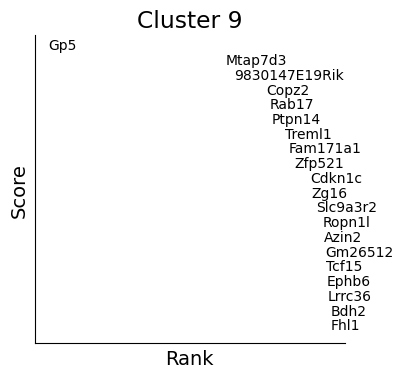

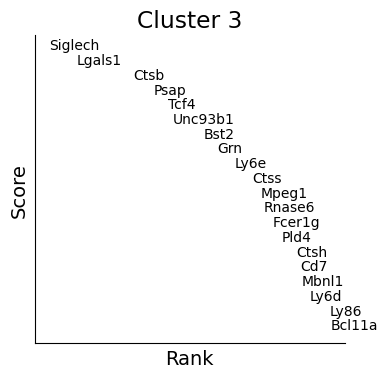

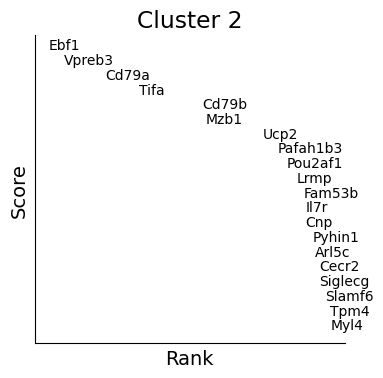

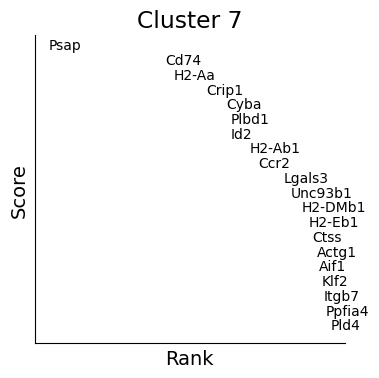

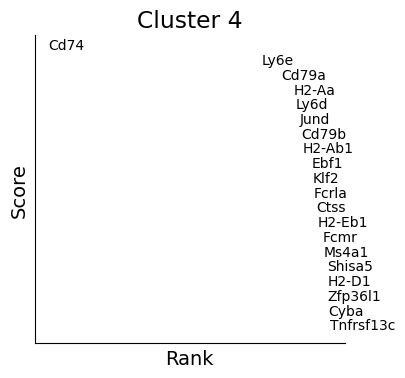

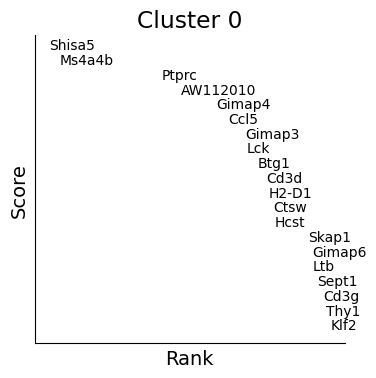

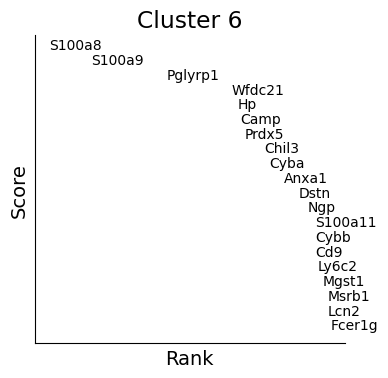

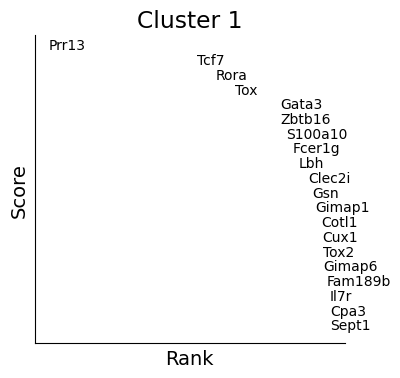

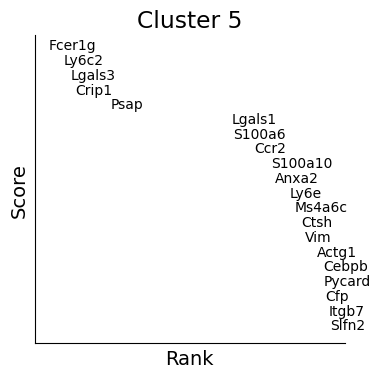

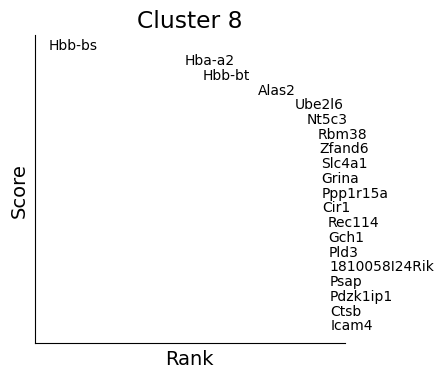

In [116]:
from matplotlib import transforms

data_for_outliers.uns['log1p']["base"] = None
sc.tl.rank_genes_groups(data_for_outliers,  groupby='leiden')


groups = data_for_outliers.obs['leiden'].unique().tolist()

n_genes = 20

for group in groups:
    rank_df = sc.get.rank_genes_groups_df(data_for_outliers, group=group).head(n_genes)
    

    plt.figure(figsize=(4,4))
    for name in rank_df['names']:
        score = rank_df.loc[rank_df['names'] == name, 'scores'].values[0]
        index = rank_df.loc[rank_df['names'] == name].index
        plt.scatter(-score, -index,s=0,color='k')
        plt.text(-score, -index[0], name, fontsize=10)

        

    sbn.despine()
    plt.xticks([])
    plt.yticks([])
    plt.ylabel('Score')
    plt.xlabel('Rank')
    plt.title('Cluster {g}'.format(g=group))
    plt.show()

In [117]:
data_for_outliers.obsm['X_umap'] = -data.obsm['X_umap']

In [118]:
data_for_outliers

AnnData object with n_obs × n_vars = 44802 × 4665
    obs: 'sample', 'exp_groups', 'percent_mito', 'n_counts', 'n_counts_log', 'n_genes', 'leiden'
    var: 'ensembl_ids', 'n_cells'
    uns: 'log1p', 'rank_genes_groups'
    obsm: 'X_umap'

/Users/magnus/.conda/envs/manuscript_1/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


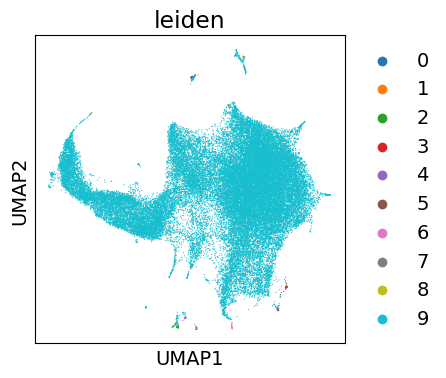

In [119]:
fig, ax = plt.subplots(figsize=(4,4))

sc.pl.umap(data_for_outliers,ax=ax, color=['leiden'])


In [120]:
groups = data_for_outliers.obs['leiden'].unique().tolist()

group_gene_dict = {}

n_genes = 20
for group in groups:
    rank_df = sc.get.rank_genes_groups_df(data_for_outliers, group=group).head(n_genes)
    group_gene_dict[group] = rank_df['names'].tolist()

In [121]:
cluster = '1'
for gene in group_gene_dict[cluster]:
    print(gene)

Prr13
Tcf7
Rora
Tox
Gata3
Zbtb16
S100a10
Fcer1g
Lbh
Clec2i
Gsn
Gimap1
Cotl1
Cux1
Tox2
Gimap6
Fam189b
Il7r
Cpa3
Sept1


Plot a colorbar for outliers:

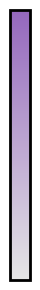

In [122]:

fig = plt.figure(figsize=(8, 3))
ax = fig.add_axes([0., 0., 0.025, 0.9])

cb_outliers = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap_outliers, 
                                orientation='vertical')
cb_outliers.set_ticks([])
cb_outliers.outline.set_linewidth(2)
 
 
cb_outliers.set_ticklabels([])
plt.show()

# Plotting gene signatures

To affirm cluster identities, we plot known marker genes on top of the UMAP:

In [123]:
data_all_genes_log = data_all_genes.copy()
data_all_genes_log_outliers = data_all_genes_log[outlier_ann_data.obs.index].copy()

#Log transform data:
sc.pp.log1p(data_all_genes_log_outliers)

In [124]:
data_all_genes_log_outliers.obsm['X_umap'] = outlier_ann_data.obsm['X_umap']

### Cell type annotation

In [126]:
gene_signatures_verified = {
                    'pDC' : ['Tcf4','Siglech', 'Pacsin1', 'Runx2', 'Spib'], # Lukowski et al (2021) Cell Press
                    'DC' : ['H2-Aa', 'H2-Ab1', 'Xcr1', 'Batf3' , 'Ciita', 'Id2'],  # Lukowski et al (2021) Cell Press
                    'GMP' : ['Lyz2', 'Ccr2', 'Ccl9','Ccl6'] + ['F13a1','Ly6c2', 'Csf1r','Prtn3'], #Mildner et al (2017) Cell Press,  Ciesla et al (2023) Cell Press
                    'B-cell' : ['Cd19', 'Cd79a', 'Cd79b', 'Vpreb3', 'Ebf1' ,'Il7r', 'Pax5'], #Rothenberg (2014) Annu. Rev. Immunol
                    'T-cell' : ['Cd3e', 'Cd3g', 'Cd3d', 'Zap70'] + ['Lck'],  #Rothenberg (2014) Annu. Rev. Immunol and (for Lck): Rothenberg et al. (2008) Nature Reviews Immunology
                    'ILC' : ['Zbtb16', 'Rora', 'Tox','Gata3', 'Tox2'],  #Seillet et al. (2016) Cell Reports
                    'Neutrophil' : ['Cebpe', 'Ly6g'] + ['Lcn2', 'Camp', 'Ngp'], #Ciesla et al (2023) Cell Press + Grieshaber-Bouyer et al. (2021)?
                    'Erythroid' : ['Klf1', 'Epor', 'Hbb-bs', 'Alas2','Slc4a1'] # An et al. (2014) Blood Advances  and Dzierzak & Philipsen et al. 2013.
                    }

pDC
DC
GMP
B-cell
T-cell
ILC
Neutrophil
Erythroid


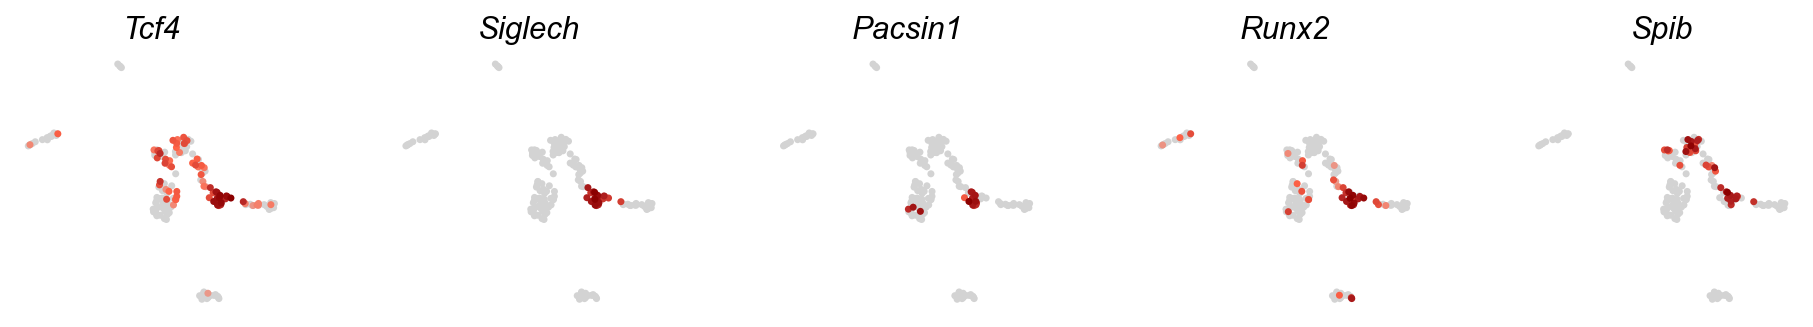

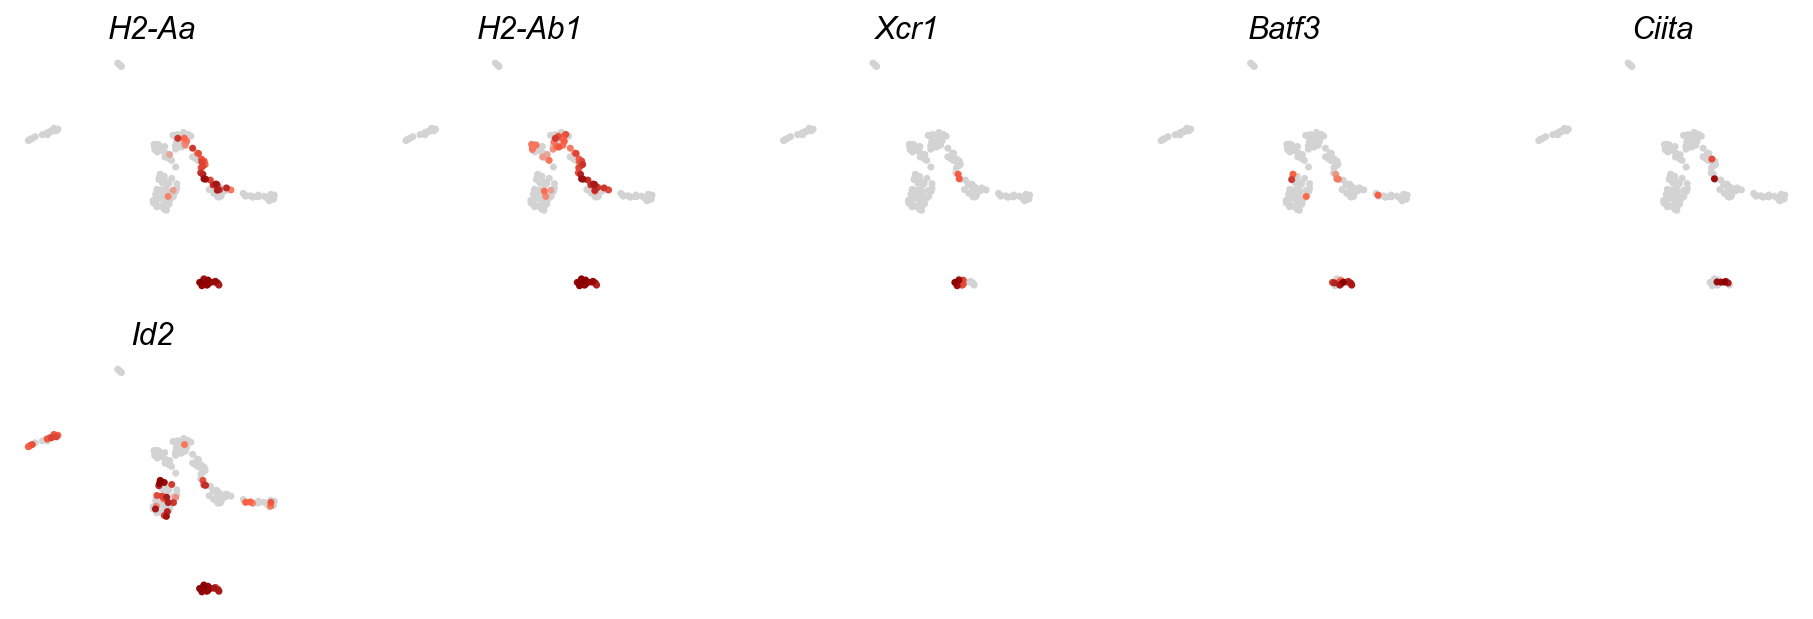

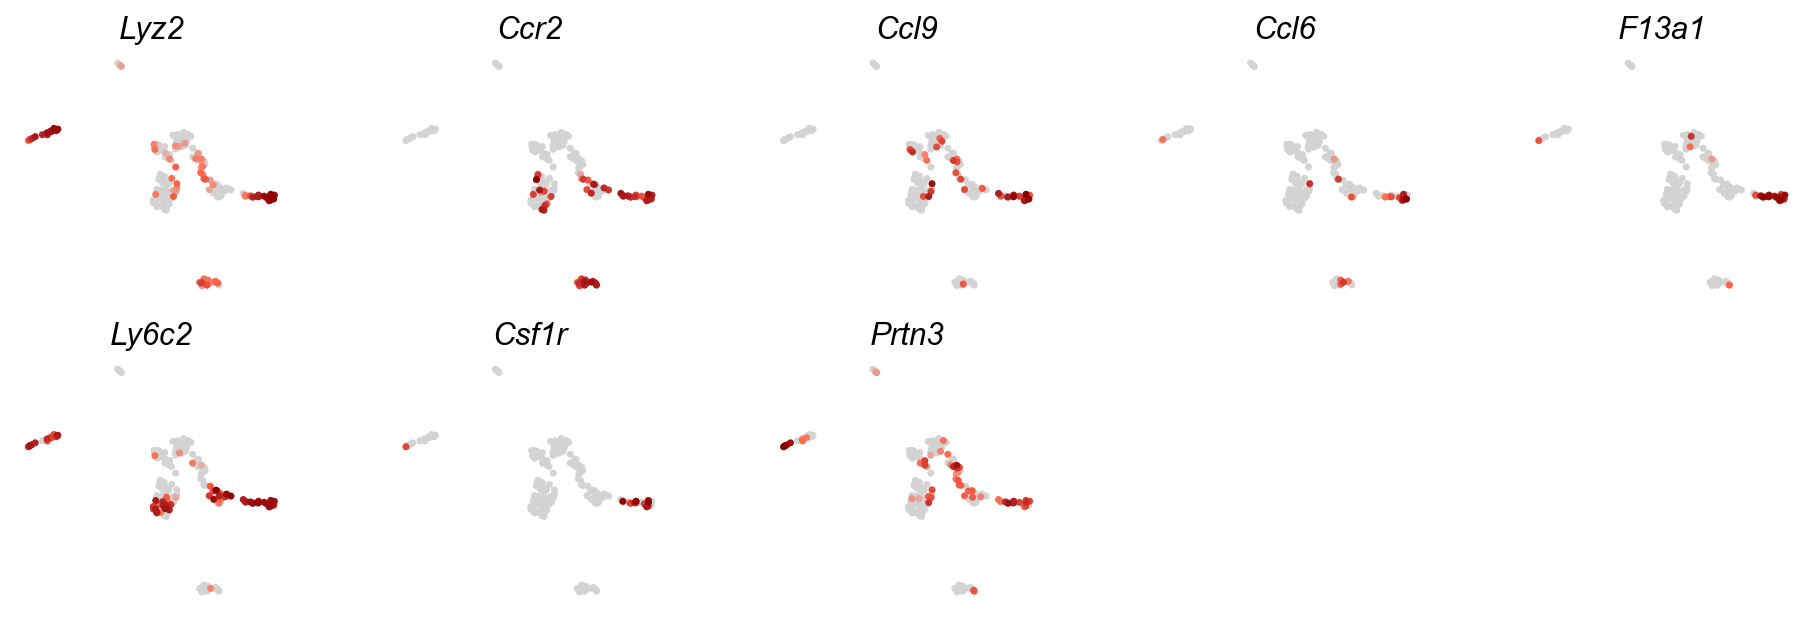

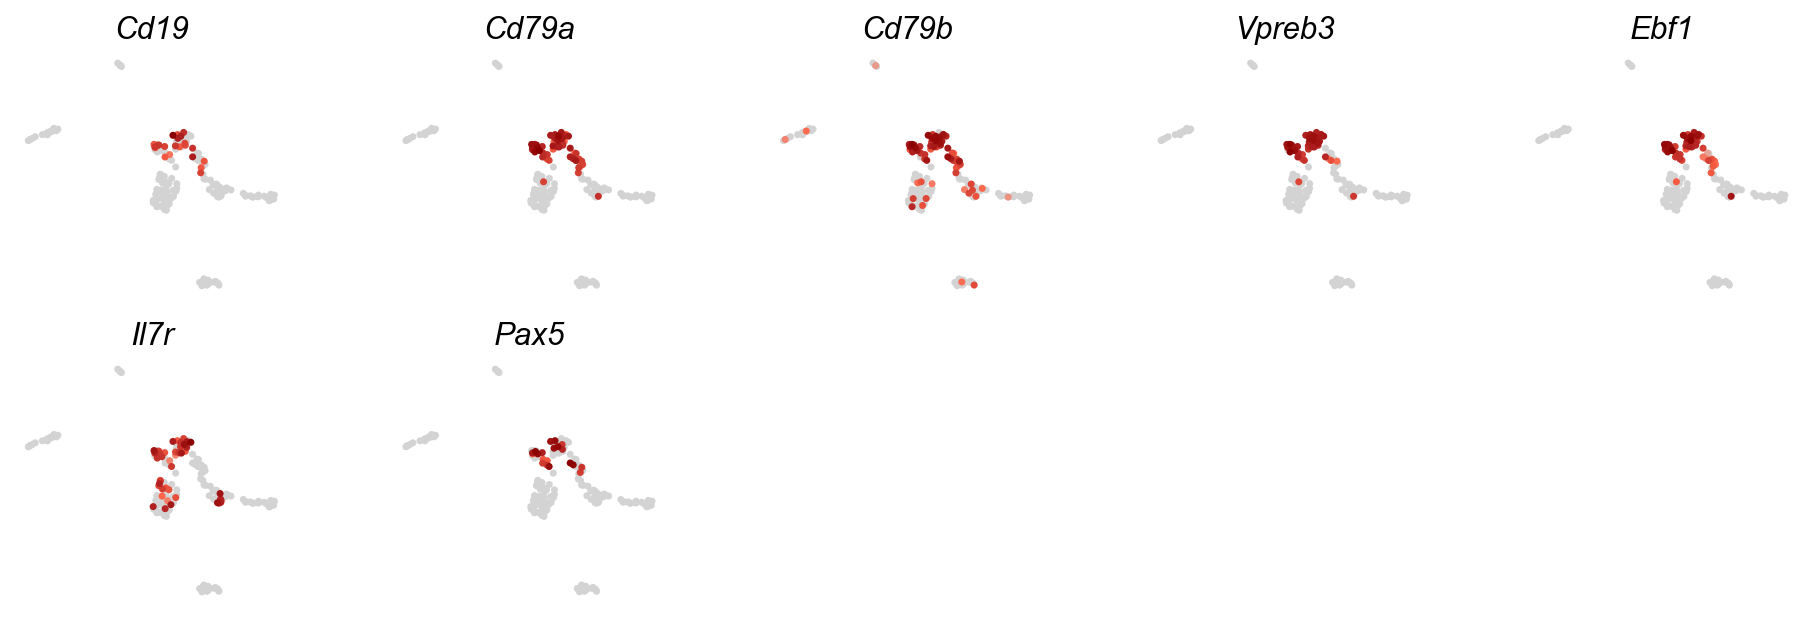

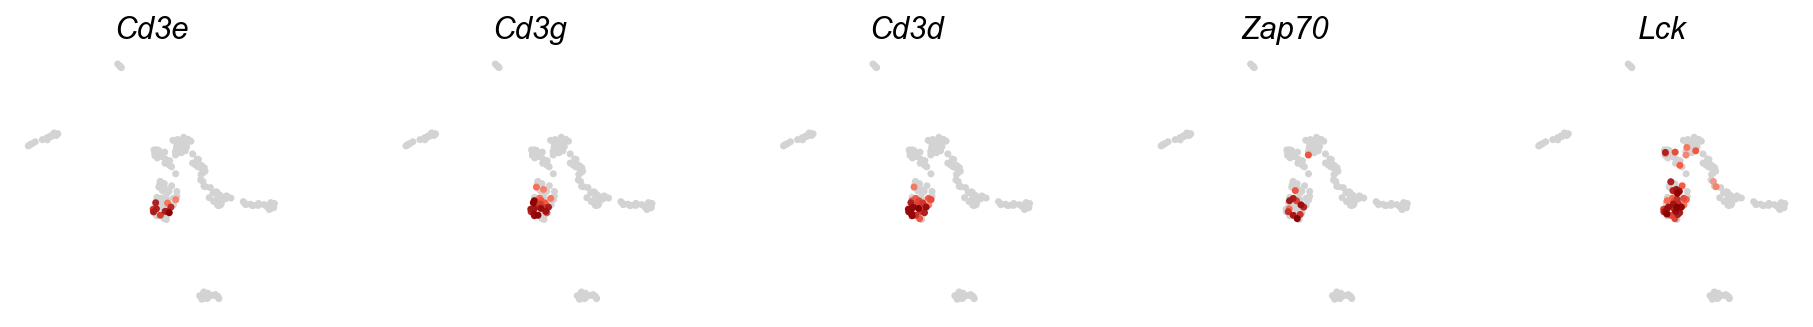

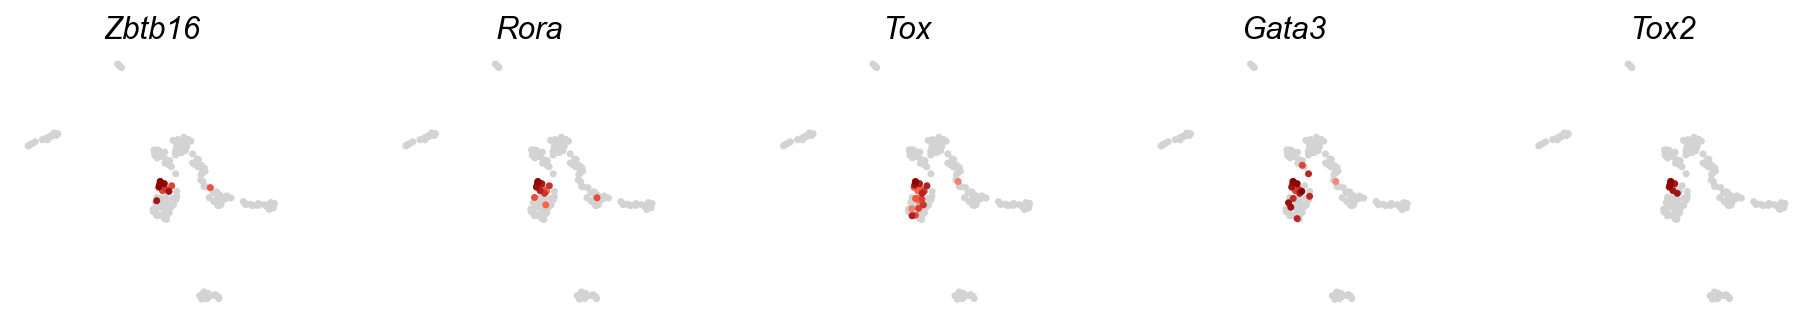

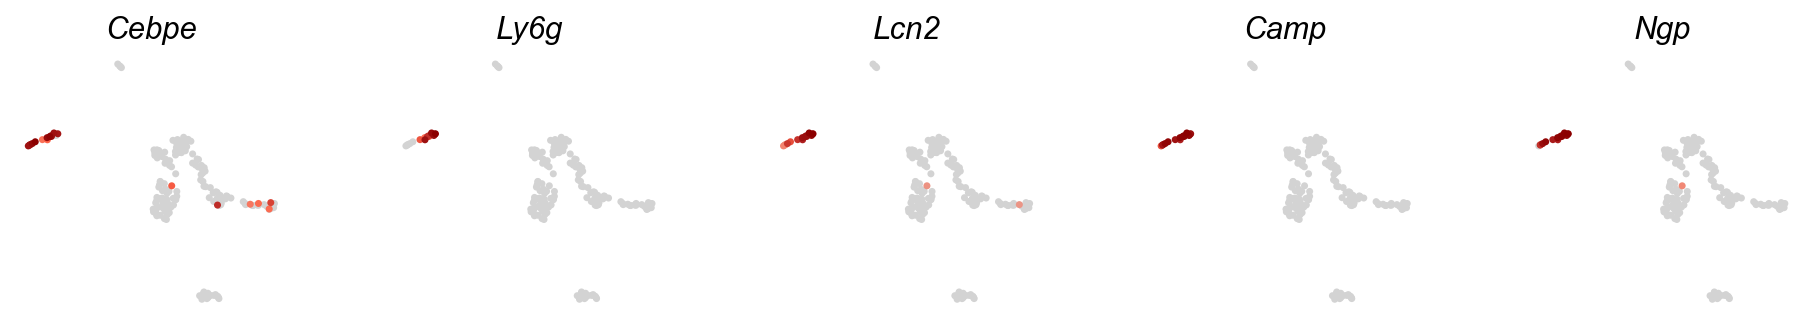

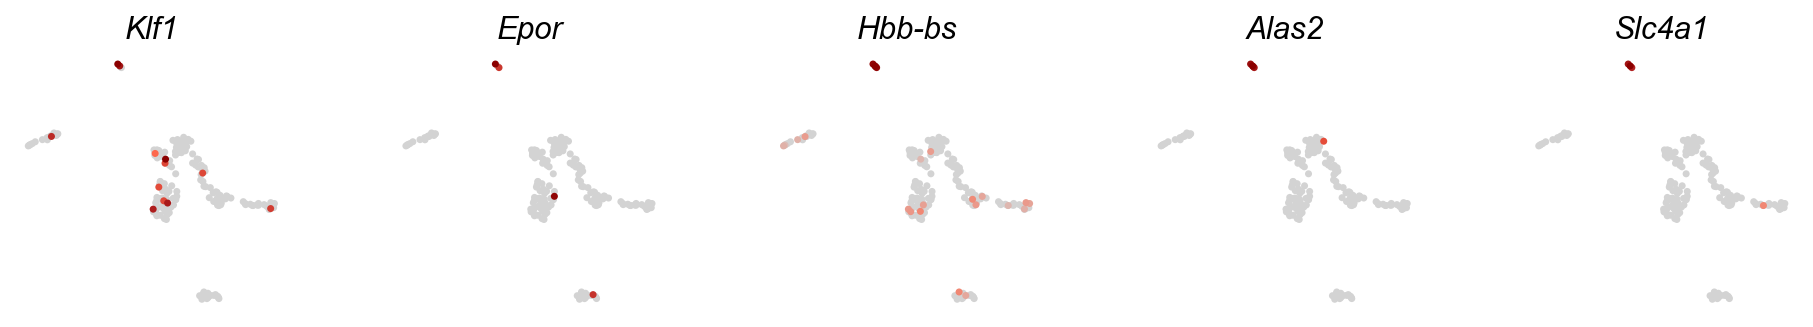

In [128]:
import matplotlib.font_manager as font_manager

font = font_manager.FontProperties(style='italic')

sc.set_figure_params(figsize=(2,2.1))

for cell_type in gene_signatures_verified:  
    print(cell_type)
    axes = sc.pl.umap(data_all_genes_log_outliers, cmap=cmap_gene, color=gene_signatures_verified[cell_type], ncols=5,show=False, s=40,frameon=False, colorbar_loc=None)
    [axes[k].set_title(gene_signatures_verified[cell_type][k],fontproperties=font) for k in range(len(axes))]

Plot genes on original UMAP:

In [129]:
data_all_genes_with_umap = data_all_genes.copy()
data_all_genes_with_umap.obsm['X_umap'] = -data.obsm['X_umap']

data_all_genes_log_with_umap = data_all_genes.copy()
data_all_genes_log_with_umap.obsm['X_umap'] = -data.obsm['X_umap']

#Log transform data:
sc.pp.log1p(data_all_genes_log_with_umap)

pDC
DC
GMP
B-cell
T-cell
ILC
Neutrophil
Erythroid


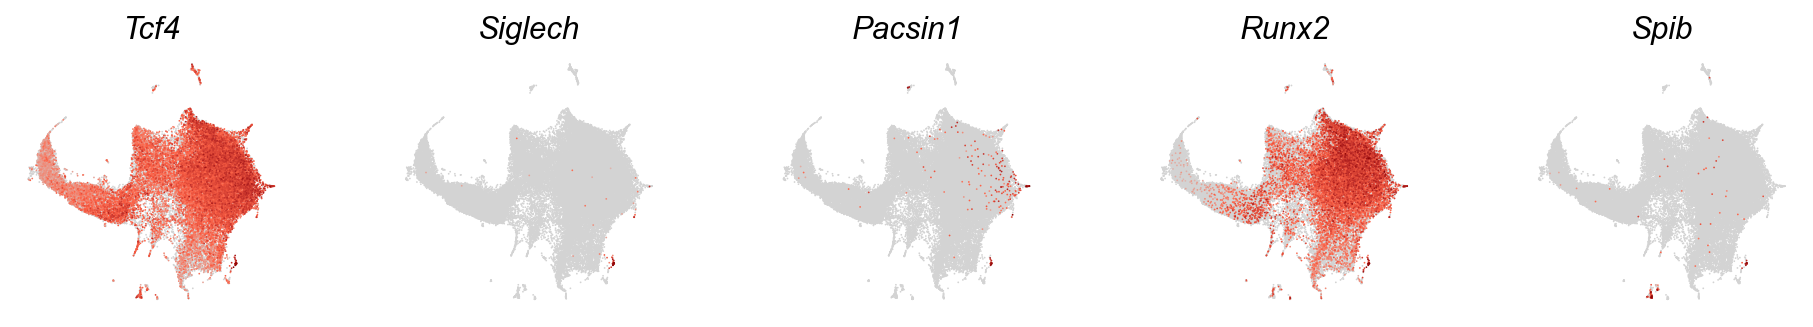

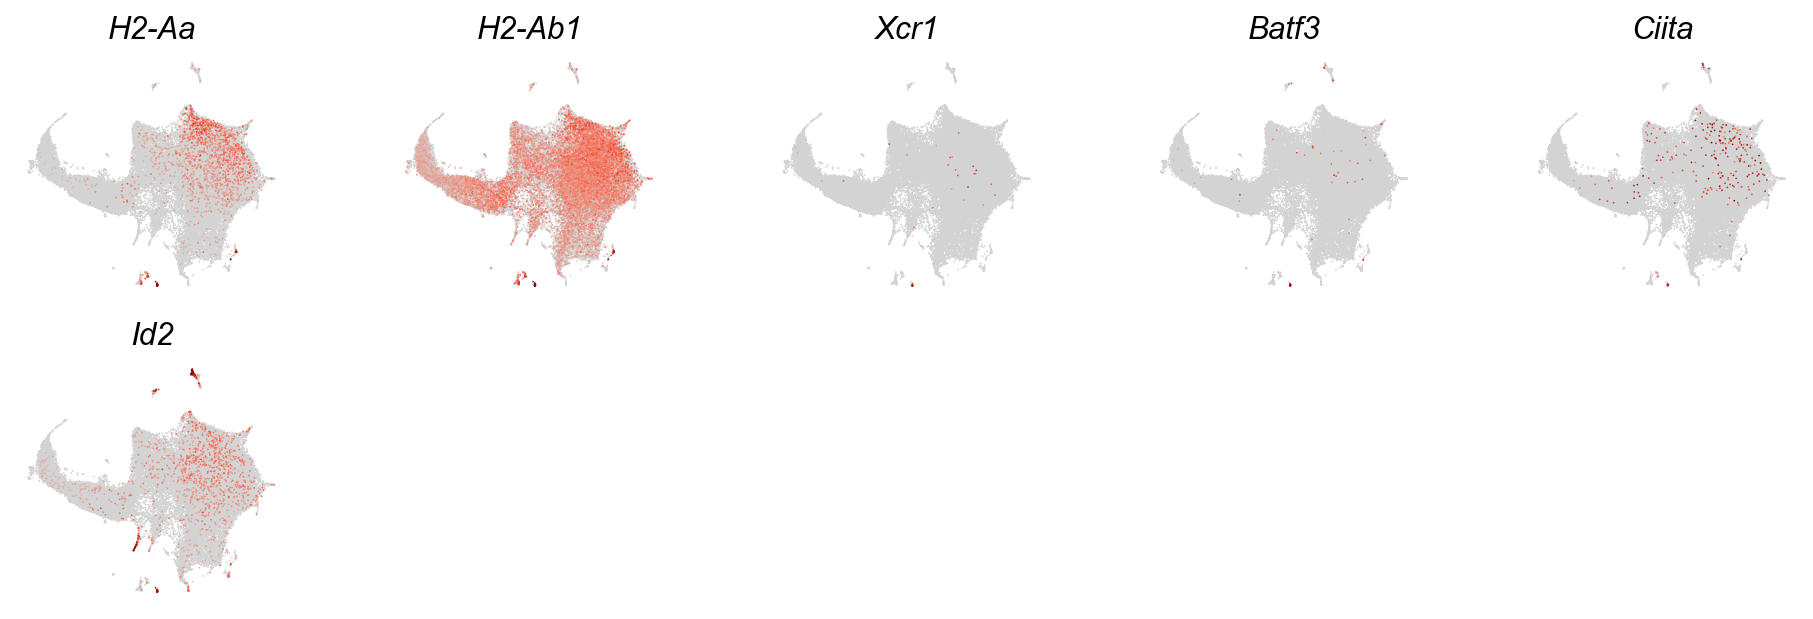

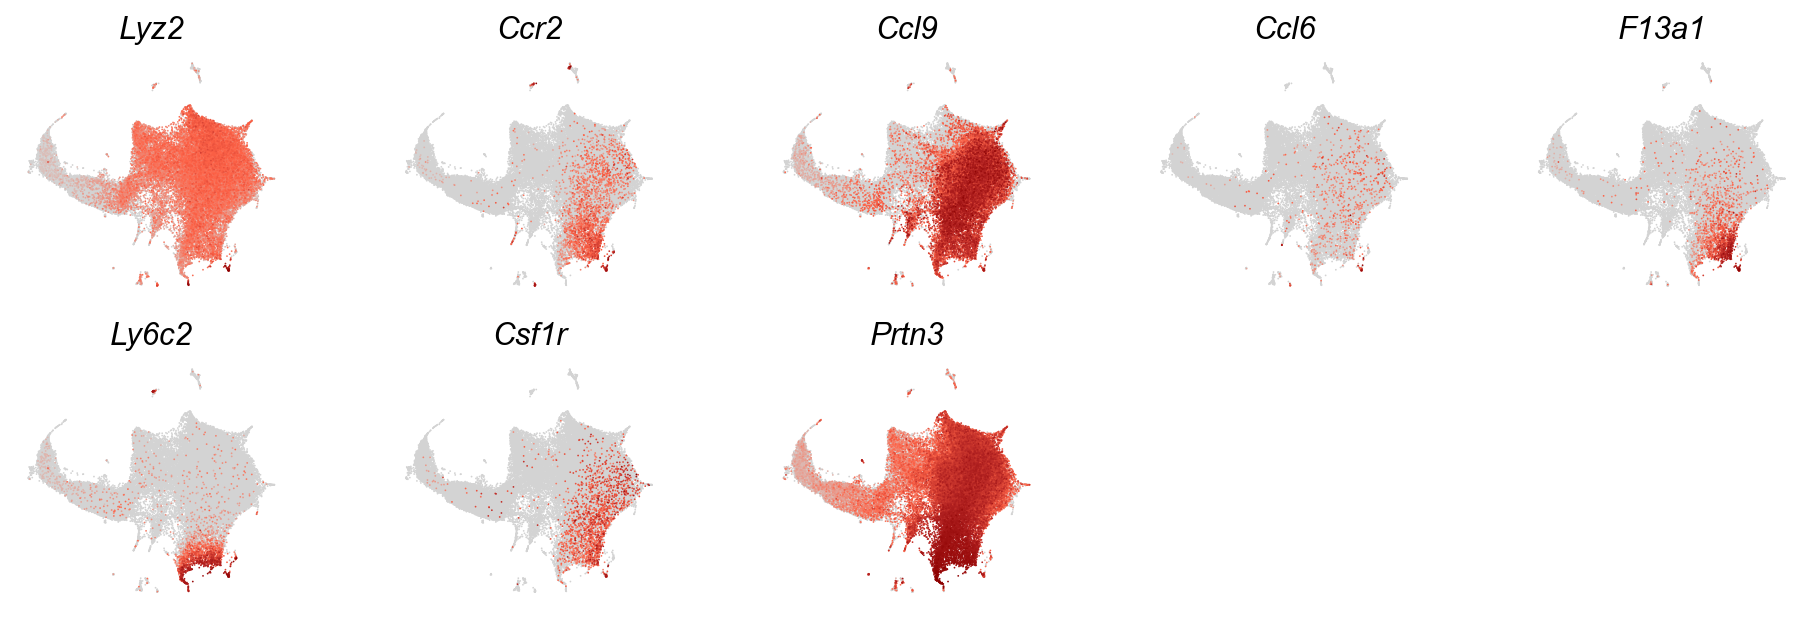

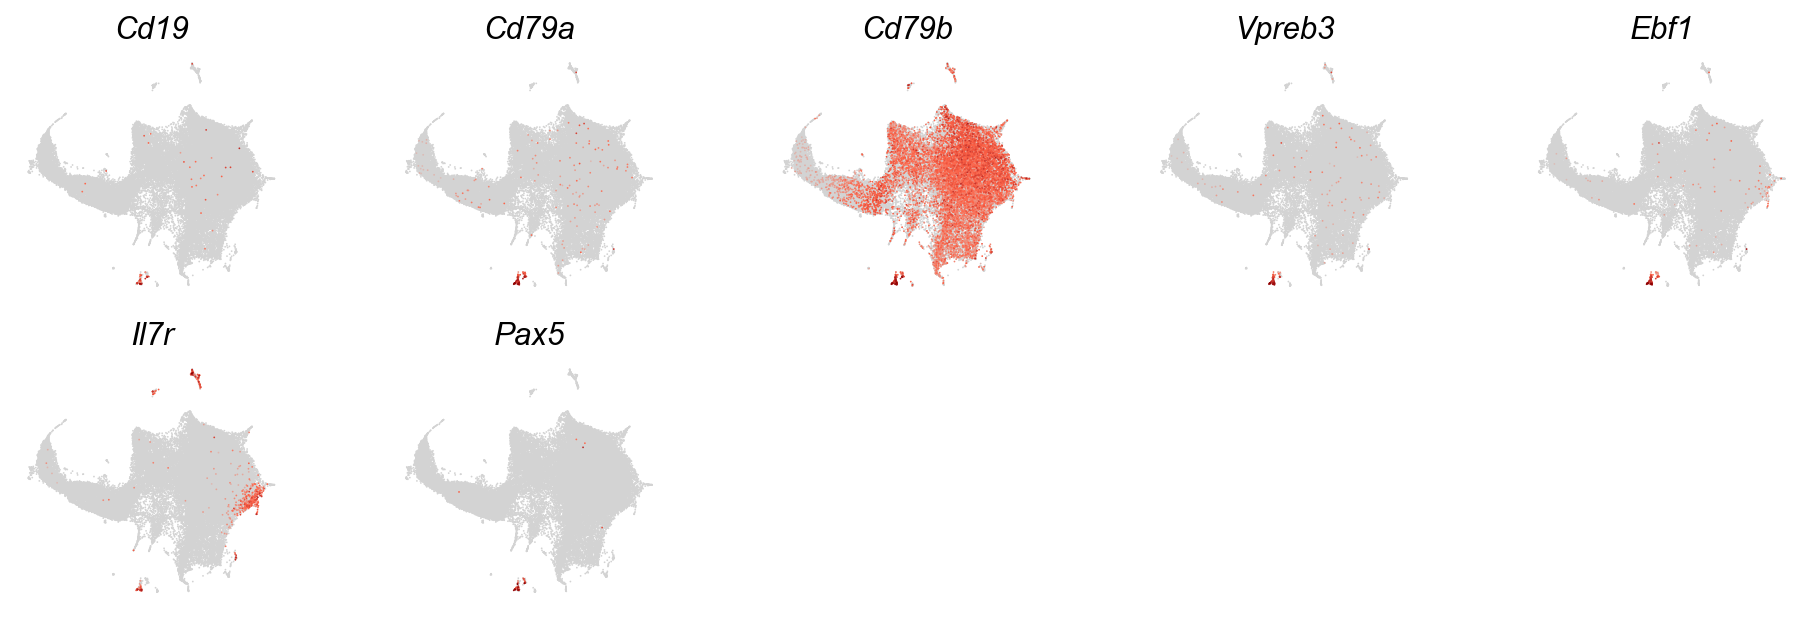

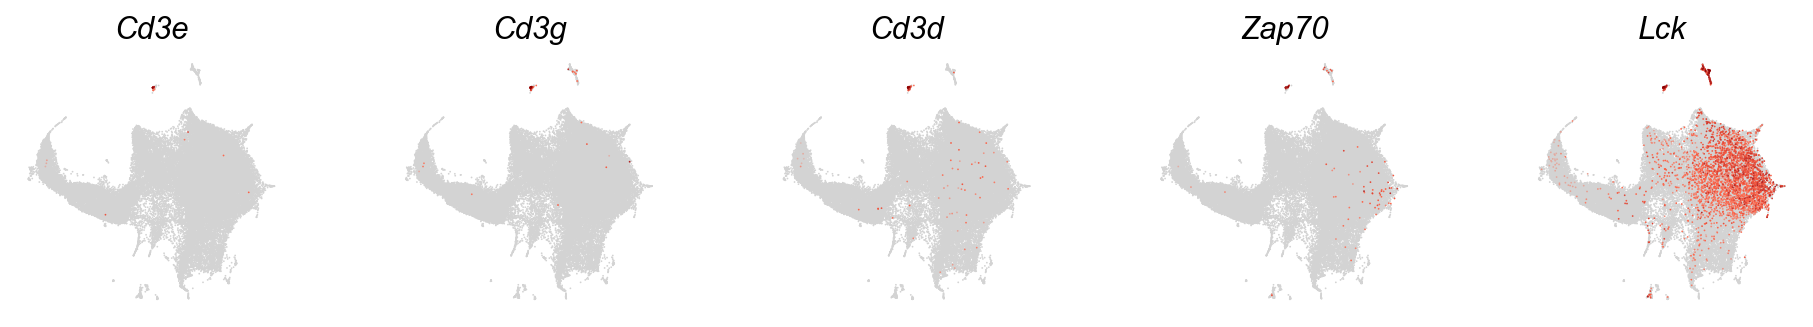

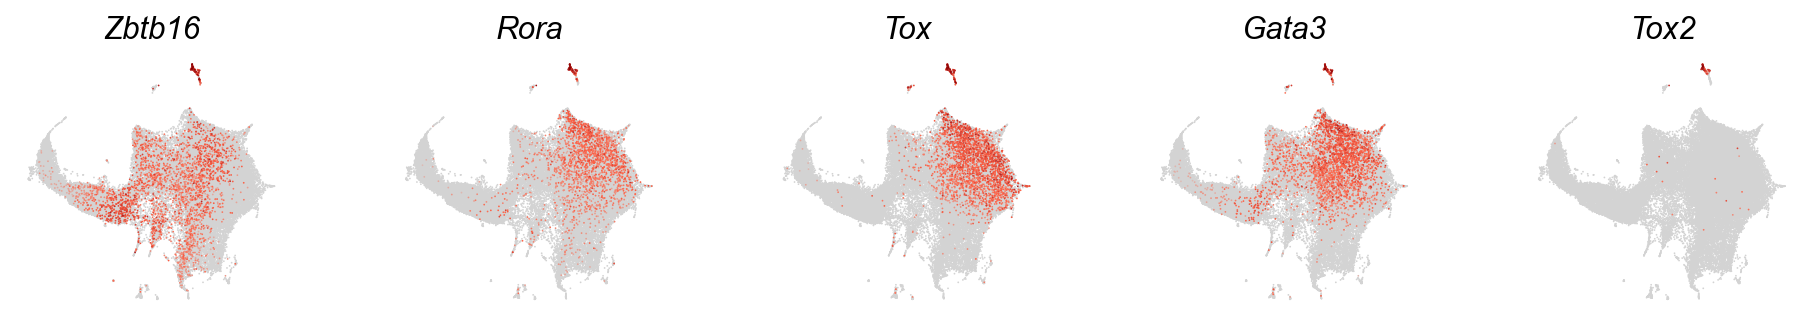

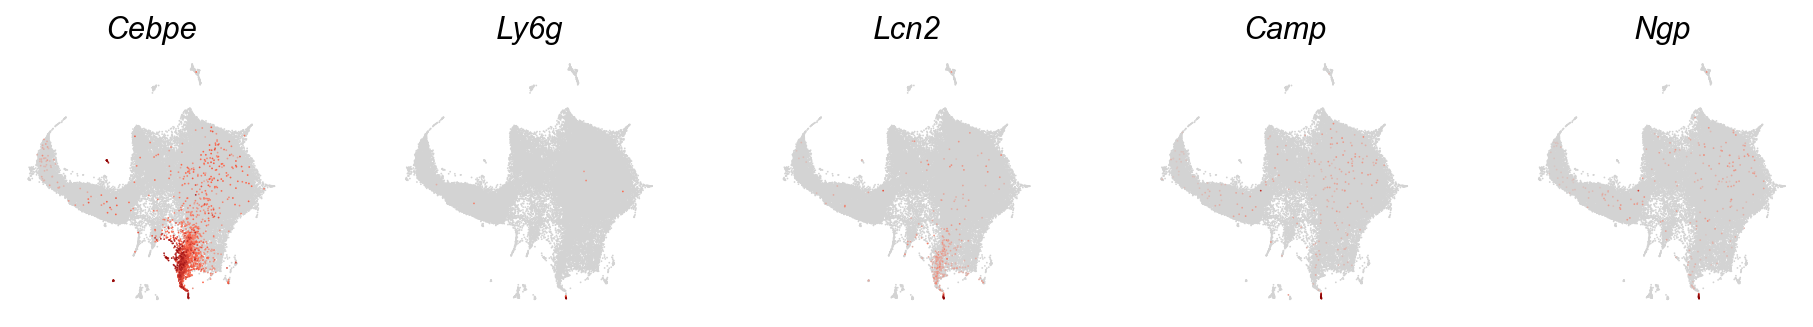

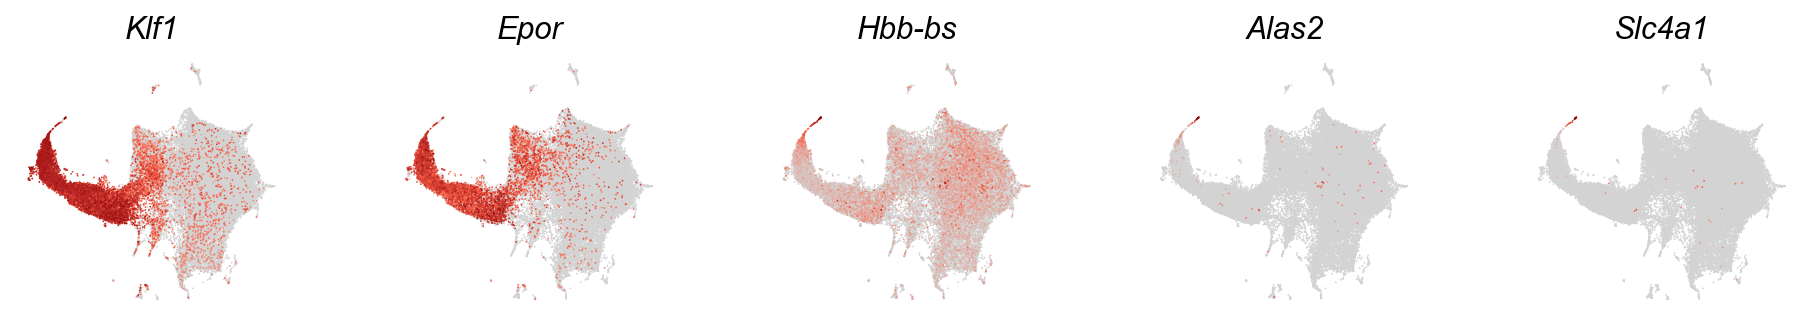

In [130]:
font = font_manager.FontProperties(style='italic')
sc.set_figure_params(figsize=(2,2.1))

for cell_type in gene_signatures_verified:
    print(cell_type)
    axes = sc.pl.umap(data_all_genes_log_with_umap, cmap=cmap_gene, color=gene_signatures_verified[cell_type], ncols=5,show=False, s=2.5,frameon=False, colorbar_loc=None)
    [axes[k].set_title(gene_signatures_verified[cell_type][k],fontproperties=font) for k in range(len(axes))]

Create a colorbar for gene expression

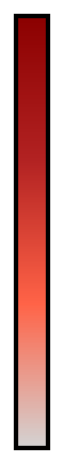

In [131]:

fig = plt.figure(figsize=(8, 3))
ax = fig.add_axes([0., 0., 0.025, 0.9])

cb_gene = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap_gene, 
                                orientation='vertical')
cb_gene.set_ticks([])
cb_gene.outline.set_linewidth(2)
 
 
cb_outliers.set_ticklabels([])
plt.show()

### Annotation based on signatures:

In [132]:
outlier_ann_data

AnnData object with n_obs × n_vars = 168 × 4665
    obs: 'sample', 'exp_groups', 'percent_mito', 'n_counts', 'n_counts_log', 'n_genes', 'leiden', 'leiden_sub_1', 'leiden_sub_2'
    var: 'ensembl_ids', 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Based on the gene signatures above, we landed on the following tentative annotation:

In [133]:
annotated_clusters = { '0' : 'T-cell',
                       '1' : 'ILC', 
                       '2' : 'B-cell',
                       '4' : 'B-cell',
                       '3' : 'pDC',
                       '5' : 'Gr/Mono',
                       '6' : 'Neutrophil',
                       '7' :'DC',
                       '8' : 'Erythroid' }

In [134]:
max(outlier_ann_data.obs['leiden_sub_2'].astype(int))

8

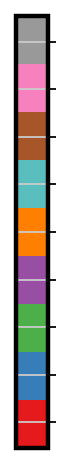

In [135]:
n_clusters = len(annotated_clusters)
fig = plt.figure(figsize=(8, 3))
ax = fig.add_axes([0., 0., 0.025, 0.9])

cb_genes = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, 
                                orientation='vertical')
cb_genes.set_ticks([])
cb_genes.outline.set_linewidth(2)
 
tick_locs = (np.linspace(0.06, 0.94 ,n_clusters))

cb_genes.set_ticks(tick_locs)
cb_genes.set_ticklabels([])
plt.show()

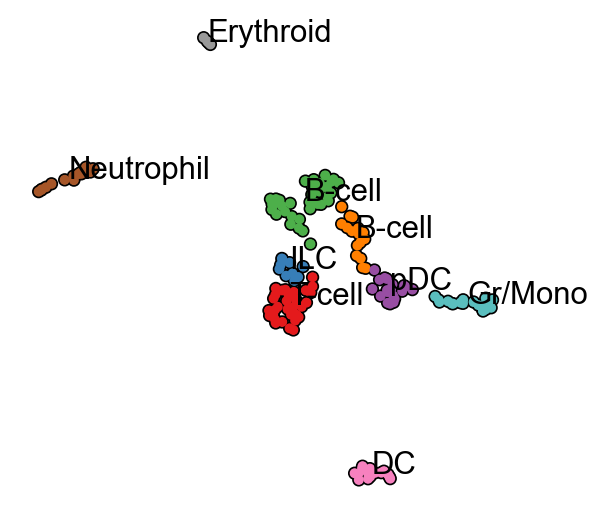

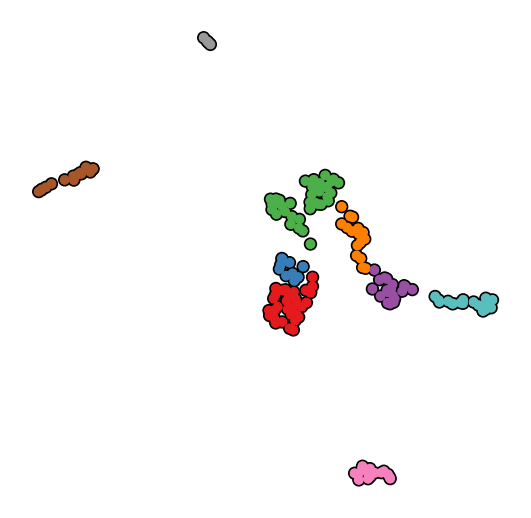

In [138]:
fig = plt.figure(figsize=(4,4))
colors_annotation = plt.get_cmap('Set1')([k for k in range(len(outlier_ann_data.obs['leiden_sub_2'].unique()))])
colors_annotation[5] = [90/255,190/255,190/255,1.]
cmap = LinearSegmentedColormap.from_list('my_cmap', colors_annotation, N=len(outlier_ann_data.obs['leiden_sub_2'].unique()))



plt.scatter(outlier_ann_data.obsm['X_umap'][:,0], outlier_ann_data.obsm['X_umap'][:,1], edgecolor='k', facecolor='none',s=25)
plt.scatter(outlier_ann_data.obsm['X_umap'][:,0], outlier_ann_data.obsm['X_umap'][:,1], 
c=outlier_ann_data.obs['leiden_sub_2'].astype(int).values, cmap=cmap,edgecolor='none',s=20)

annotations = [anno for anno in gene_signatures_verified]

txt_locs = { str(k) : np.mean(outlier_ann_data[outlier_ann_data.obs['leiden_sub_2'].astype(int).loc[outlier_ann_data.obs['leiden_sub_2'].astype(int) == k].index].obsm['X_umap'].toarray(), axis=0) for k in range(max(outlier_ann_data.obs['leiden_sub_2'].astype(int))+1)}


[plt.text(txt_locs[cluster][0], txt_locs[cluster][1], annotated_clusters[cluster]) for cluster in annotated_clusters]

sbn.despine(bottom=True,left=True)
plt.xticks([])
plt.yticks([])  
 
plt.show()

fig = plt.figure(figsize=(4,4))
plt.scatter(outlier_ann_data.obsm['X_umap'][:,0], outlier_ann_data.obsm['X_umap'][:,1], edgecolor='k', facecolor='none',s=25)
plt.scatter(outlier_ann_data.obsm['X_umap'][:,0], outlier_ann_data.obsm['X_umap'][:,1], 
c=outlier_ann_data.obs['leiden_sub_2'].astype(int).values, cmap=cmap,edgecolor='none',s=20)

annotations = [anno for anno in gene_signatures_verified]

txt_locs = { str(k) : np.mean(outlier_ann_data[outlier_ann_data.obs['leiden_sub_2'].astype(int).loc[outlier_ann_data.obs['leiden_sub_2'].astype(int) == k].index].obsm['X_umap'].toarray(), axis=0) for k in range(max(outlier_ann_data.obs['leiden_sub_2'].astype(int))+1)}


sbn.despine(bottom=True,left=True)
plt.xticks([])
plt.yticks([])  
plt.show()
